<div style="border-top: 3px solid #0a6d91; padding: 15px; display: flex; align-items: center; justify-content: space-between;">

  <!-- Left text -->
  <div style="flex: 1; padding-right: 20px;">
    <h2 style= display: inline-block; padding: 5px 10px; border-radius: 3px;">
      MAPD (mod.B) Final Project
    </h2>
    <h3>Anomaly detection and <br>Predictive maintenance for
industrial devices</h3>
  </div>

  <!-- Right images -->
  <div style="flex: 0 0 auto; display: flex; align-items: center; gap: 20px;">
    <img src="https://th.bing.com/th/id/R.f158dd00f7e0e326ff081cf1acb39901?rik=tfJW%2frH3keCJ%2fg&riu=http%3a%2f%2fboostlab.dfa.unipd.it%2fimg%2flogo_pod.png&ehk=Th6GDiUuQTgD%2faBhIK7JUi15%2bG%2f35LzMJV9PFEPd9rg%3d&risl=&pid=ImgRaw&r=0" alt="PoD" width="250"/>
    <img src="https://www.unidformazione.com/wp-content/uploads/2018/04/unipd-universita-di-padova-1024x463.png" alt="UNIPD" width = "350" />
  </div>

</div>
<div style="border-bottom: 3px solid #0a6d91">
    <p><strong>Authors</strong></p>
    <ul>
      <li>Boscolo Marco (2157559)</li>
      <li>La Rovere Francesco (2164968)</li>
      <li>Montagner Nicolò (2165809)</li>
      <li>Sabatini Raffaele (2165739)</li>
    </ul>
</div>


## Table of Contents
* 1. [**Data Preprocessing**](#1-dataset-preprocessing)
    * 1.1. **Setting Spark session**
    * 1.2. **Preliminary Operations**
    * 1.3. **Timestamp Analysis**
* 2. [**Data Preparation**](#2-data-preparation)
    * 2.1. **Create Grid**
    * 2.2. **Build Blocks**
    * 2.3. **Fill Nulls**
    * 2.4. **Usless Sensors**
    * 2.5. **Analsis on blocks distribution**
* 3. [**Anomaly Detection (engines)**](#3-anomaly-detection-(engines))
    * 3.1. **Distributed Analysis for anomaly Detection**
    * 3.2. **Linear Correlation setup**
    * 3.3. **Correlation analysis**
* 4. [**Anomaly Detection (temperature)**](#4-anomaly-detection-(temperature))
    * 4.1. **Correlation between device load and external temperature**
* 5. [**Predictive Maintainance**](#5-predictive-maintainance)
    * 5.1. **Conversion of alarms A5 and A9**
    * 5.2. **Correlation analysis for alarms**
    * 5.3. **Add predictive flag**
    * 5.4. **Blocks between fault signals**
    * 5.5. **Sensors behaviour**
    * 5.3. **Support Vector Machine**
    * 5.4. **Random Forest**
    * 5.5. **Maintenance in action**
* 6. [**Conclusion: Cluster Optimization**](#6-conclusions-cluster-parameters-optimization)

In [1]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("ProjectDocker") \
    .config("spark.executor.memory", "1750m") \
    .config("spark.cores.max", "8") \
    .config("spark.default.parallelism", "16") \
    .config("spark.sql.shuffle.partitions", "16") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
    .config("spark.sql.debug.maxToStringFields", 1000) \
    .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/30 13:09:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# # df_final_088.write.mode("overwrite").parquet("df_final_088.parquet") #save file
#df_final_088 = spark.read.parquet("df_lavorare.parquet").repartition(8) #read file

In [3]:
core = 16
nome = "marco"

# Users mapping → (SparkUI, user)
maps = {
    "nicolò":   (4040, "user_a"),
    "marco":    (4041, "user_b"),
    "francesco":(4042, "user_c"),
    "raffaele": (4043, "user_d"),
}

SparkUI, user = maps[nome]
Npartition = 1*core 
Nexecutors = 4

# 1) Dataset preprocessing

## Setting Spark Session and importing libraries

Here we import the standrad library and all the dependencies used for the project. <br>
The Spark session is created in such a way that everyone in the group can access the shared resourses of the cluster.

In [4]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

from math import ceil, floor
from functools import reduce
from IPython.display import display, HTML

from pyspark import SparkFiles
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import (
    StructType, StructField, IntegerType, DoubleType, 
    TimestampType, BooleanType
)

from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors as MLLibVectors
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, LinearSVC, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from pyspark.sql.functions import (
    col, lit, expr, when, coalesce, corr, array, countDistinct, greatest, least, isnull,
    approx_count_distinct, count, count_if, row_number,  sum as spark_sum, abs as spark_abs, sqrt as spark_sqrt,
    round as spark_round, min as spark_min, max as spark_max, avg as spark_avg, stddev as spark_stddev,
    first, last, lag, lead, desc, asc, bool_or, explode, sequence,
    from_unixtime, to_date, unix_timestamp, array_repeat, window, 
    min_by, mode, concat, monotonically_increasing_id, mean, rand
)

In [5]:
# Setting spark session

os.environ["PYSPARK_PYTHON"] = "/opt/miniconda3/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/miniconda3/bin/python"

configs = {
    "spark.scheduler.mode": "FAIR",                                  # Multi-user scheduler
    "spark.scheduler.pool": user,                                    # User pool
    "spark.scheduler.allocation.file": "file:///usr/local/spark/conf/fairscheduler.xml",  # Scheduler config file
    "spark.executor.memory": "3200m",                                # Executor RAM
    "spark.cores.max": core,                                         # Total cores
    "spark.executor.instances": Nexecutors,                          # Number of executors
    "spark.sql.shuffle.partitions": Npartition,                      # Shuffle partitions
    "spark.sql.execution.arrow.pyspark.enabled": "true",             # Enable Arrow
    "spark.sql.execution.arrow.pyspark.fallback.enabled": "false",   # No Arrow fallback
    "spark.dynamicAllocation.enabled": "false",                      # No dynamic allocation
    "spark.shuffle.service.enabled": "false",                        # No shuffle service
    "spark.ui.port": SparkUI,                                        # Custom UI port
    "spark.sql.debug.maxToStringFields": 1000                        # Debug fields limit
}

spark_builder = SparkSession.builder \
   .appName("ProjectCloudVeneto") \
   .master("spark://10.67.22.135:7077")

for key, value in configs.items():
   spark_builder = spark_builder.config(key, value)

spark = spark_builder.getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/30 12:54:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
# clean up beafore running
spark.catalog.clearCache()
gc.collect()

# Set spark to only display errors
sc.setLogLevel("ERROR")

sensors = ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']
alarms = ['A5', 'A9', 'ComError']
engines = ["S117", "S118", "S169", "S170"]
print(f"There are {len(sensors)} sensors.\n")

There are 130 sensors.



## Preliminary operations

We load the data from the */mnt/shared/* directory on the master node, which is accessible to the other workers via NFS (Network File System), configured through CloudVeneto.

In [7]:
df = spark.read.option("header", True).option("inferSchema", True).csv("file:///mnt/shared/dataset.csv").repartition(4, col("hwid"))

# convert milliseconds into seconds
df = df.withColumn("when", spark_round(col("when") / 1000).cast(IntegerType()))

In [8]:
# inspect dataset
df.printSchema()

root
 |-- when: integer (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: integer (nullable = true)



In [9]:
df.orderBy("when").show(5)

[Stage 4:============================================>              (3 + 1) / 4]

+----------+------+------+-----+
|      when|  hwid|metric|value|
+----------+------+------+-----+
|1601510422|SW-106|   S49|    0|
|1601510422|SW-106|   S56|    0|
|1601510422|SW-106|   S50|    0|
|1601510422|SW-106|   S53|    0|
|1601510422|SW-106|   S54|    0|
+----------+------+------+-----+
only showing top 5 rows



Inspecting the original dataframe reveals a high level of redundancy in the data structure, as each row corresponds to a unique combination of *when*, *hwid*, and *sensor.

In [10]:
# inspect hardwares of dataset
df_hwid = df.groupBy("hwid").agg(count(col("*")).alias("# rows"))
df_hwid.show()

[Stage 9:=======================================>                   (2 + 1) / 3]

+------+--------+
|  hwid|  # rows|
+------+--------+
|SW-115|46242916|
|SW-088|42095692|
|SW-065|27576413|
|SW-106|26187749|
+------+--------+



In [11]:
list_hw = df.select("hwid").distinct().rdd.flatMap(lambda x : x).collect()
list_hw.sort()

In [12]:
# defining a useful print function for later
def print_separator(hw): 
    return display(HTML(f"<div style='text-align:center; font-size:24px; font-weight:bold; margin:20px 0;'>--------------------------{hw}--------------------------</div>"))

The first operation on the entire dataset is the pivot of the sensors (metrics) grouped by hardware, in this way the columns of the new dataset represent the measurements of the sensors at each given time for each hardware.

In [13]:
df_all_hw = (df.groupBy("hwid", "when")
                   .pivot("metric")
                   .agg(first("value"))
                   .withColumn("time", from_unixtime(col("when"))) # column for "human" time format
                   .orderBy("hwid", "when"))

df_all_hw = df_all_hw.persist()
df_all_hw.count()

2159880

In [14]:
#Reformat the data with the correct decimal

decimals = {'P5': 1, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'P10': 1, 'P16': 1, 'P17': 1, 'P18': 1, 'S3': 1, 'S6': 1, 'S19': 1, 'S37': 1, 'S39': 1, 'S40': 1, 'S41': 1,'S42': 1, 'S43': 1, 'S45': 1, 'S46': 1, 'S47': 1, 'S49': 1, 'S50': 1, 'S69': 1, 'S70': 1, 'S71': 1, 'S72': 1, 'S80': 1, 'S81': 1, 'S83': 1, 'S97': 1, 'S100': 1, 'S101': 1, 'S102': 1, 'S106': 1, 'S107': 1, 'S108': 1, 'S109': 1, 'S110': 1, 'S122': 2, 'S124': 1, 'S126': 1, 'S128': 1, 'S129': 1, 'S137': 1, 'S138': 1, 'S140': 1, 'S154': 1, 'S157': 1, 'S158': 1, 'S159': 1, 'S163': 1, 'S164': 1, 'S165': 1, 'S166': 1, 'S167': 1, 'S178': 2, 'S180': 1}

columns_to_transform = [(col(c) / (10**decimals[c])).alias(c) if c in decimals else col(c) for c in df_all_hw.columns]
df_all_hw = df_all_hw.select(*columns_to_transform)

In [15]:
engines = ["S117", "S118", "S169", "S170"]
alarms = ['A5', 'A9', 'ComError']
sensors = [s for s in df_all_hw.columns if s not in [ "when","time","hwid",*alarms,*engines ] ]

print("New dataframe structures (just engines sensors are shown):\n")
df_all_hw.select("when","time",*engines).orderBy(col("time").asc()).show(5)

New dataframe structures (just engines sensors are shown):

+----------+-------------------+----+----+----+----+
|      when|               time|S117|S118|S169|S170|
+----------+-------------------+----+----+----+----+
|1601510422|2020-10-01 00:00:22|   0|   1|NULL|NULL|
|1601510425|2020-10-01 00:00:25|NULL|NULL|   0|   1|
|1601510453|2020-10-01 00:00:53|   0|   1|NULL|NULL|
|1601510455|2020-10-01 00:00:55|NULL|NULL|   0|   1|
|1601510459|2020-10-01 00:00:59|   0|   0|NULL|NULL|
+----------+-------------------+----+----+----+----+
only showing top 5 rows



In [16]:
print(f"There are {len(sensors)} sensors (excluding 3 alarms and 4 engines indicators):\n")
print( sensors )

There are 126 sensors (excluding 3 alarms and 4 engines indicators):

['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S17', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']


## Timestamp analysis

Analysis of the timestamps to better understand the data distribution for each hardware. <br>
Measures are not distributed homogeneously in time, therefore we need to undersand the best way to represent and parallelize the data. <br>
In this section we study how the time difference of contiguous records is distributed.

In [17]:
def compute_time_differences(df):
    w = Window.partitionBy("hwid").orderBy("when")
    df_with_diff = df.withColumn("prev_time", lag("when").over(w)) \
                   .withColumn("time_diff", col("when") - col("prev_time")) \
                   .filter(col("time_diff").isNotNull())
    
    df_freq = df_with_diff.groupBy("hwid", "time_diff").count()
    return df_freq.orderBy("hwid", "time_diff")

In [18]:
def plot_diff_histogram(df, min_diff, max_diff, delta, ax=None, threshold=0):
    filtered_df = df[(df['time_diff'] >= min_diff) & (df['time_diff'] <= max_diff)]
    bins = int((max_diff - min_diff) / delta)
    title = f"Time Difference Events (range {min_diff} - {max_diff} [s])"
    
    if ax is None:
        plt.figure(figsize=(10, 6))
        plt.hist(filtered_df['time_diff'], bins=bins, weights=filtered_df['count'], 
                 color="steelblue", edgecolor="black")
        plt.title(title)
        plt.xlabel("Time difference [s]")
        plt.ylabel("Counts")
        if threshold > 0:
            plt.axvline(threshold, color="red", linestyle="--")
            plt.text(threshold, plt.ylim()[1]*0.7, f"{threshold} [s]", 
                     rotation=90, color="red", va="top", ha="right")
        plt.show()
    else:
        ax.hist(filtered_df['time_diff'], bins=bins, weights=filtered_df['count'], 
                color="steelblue", edgecolor="black")
        ax.set_title(title)
        ax.set_xlabel("Time difference [s]")
        ax.set_ylabel("Counts")
        if threshold > 0:
            ax.axvline(threshold, color="red", linestyle="--")
            ax.text(threshold, ax.get_ylim()[1]*0.7, f"{threshold} [s]", 
                    rotation=90, color="red", va="top", ha="right")

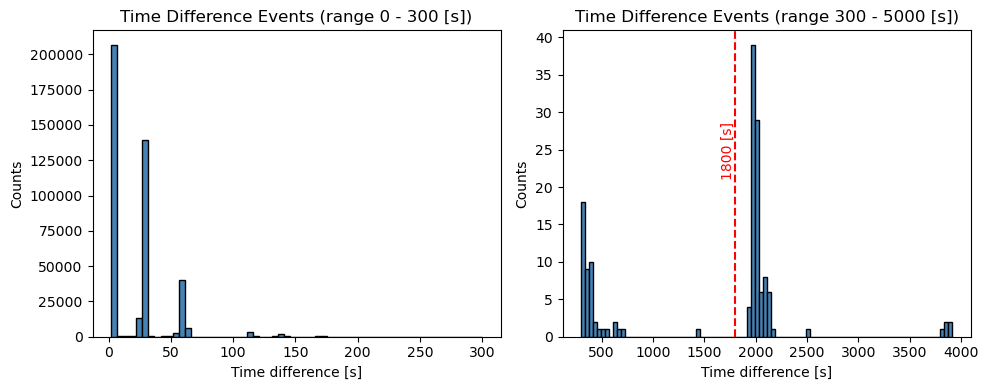

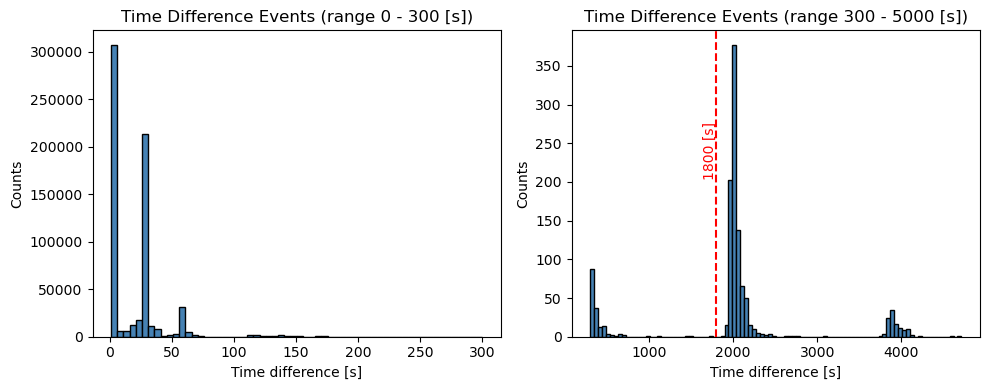

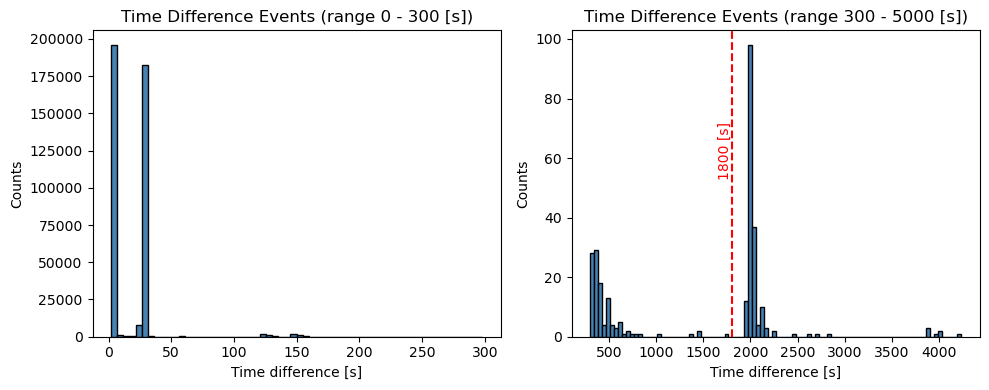

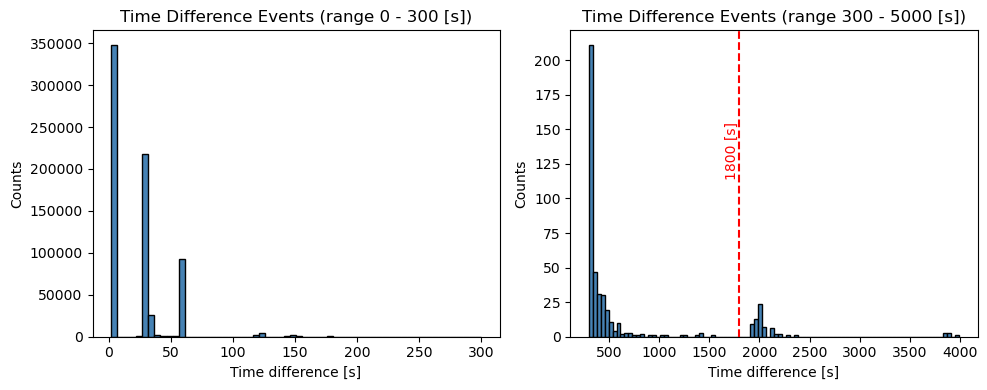

In [19]:
TimestampDiff = compute_time_differences(df_all_hw)

for hw in list_hw:
    print_separator(hw)
    
    dfDiffpandas = TimestampDiff.where(col("hwid")==hw).toPandas()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    plot_diff_histogram(dfDiffpandas, min_diff=0, max_diff=300, delta=5, ax=ax1)
    plot_diff_histogram(dfDiffpandas, min_diff=300, max_diff=5000, delta=50, ax=ax2, threshold=1800)
    
    plt.tight_layout()
    plt.show()

# 2) Data preparation

Preprocessing of the dataset. It is necessary to tackle the results from *Timestamp analysis* and to handle the NULL values introduced by the pivot of the dataset when there are no measurement in a given time ("when" column) for some sensors.

* The __CreateGrid__ allows to create an homogeneous separation grid between records (in our case "interval" = 1 minute), averaging the continuous records in the same "interval" and taking the maximum value of the binary records. <br> IMPORTANT: if in a given interval there are no records at all, this interval is empty therefore not present in the dataset.

* The __BuildBlocks__ creates a new column "BlockID" that identifies independent groups of records. A group of records is independent if between the $i$-th and the $(i+1)$-th record there pass more than 30 minutes; this threshold in based on the observed patterns in timestamp distributions above. <br> This allows to partition the dataset by "BlockID" for a better parallelization of the code. <br> IMPORTANT: in light of what said before, the number of rows in a block and the time elapsed in the block might not correspond. e.g. a block can contain 30 records, but this doesn't necessarily correspond to 30 minutes elapsed since some "interval" might have been empty. The code has been designed to appropriately handle this discrepancy across all its parts.

* The __FillNull__ replace eventual NULL values with the closest non-NULL one in the defined max_interval (4 minutes). The remaining NULL values -about the 0.06%- are dropped.

* In __UselessSensors__, we drop sensors with a constant value throughout the entire time span of the dataset.

In [20]:
interval = 60 #seconds for CreateGrid
BlockID_separation = 30 #minutes
FillNull_max_interval = 4 #miutes

## CreateGrid

In [21]:
#Create a grid of "interval" seconds in order to have homogeneous separation of data. 
def CreateGrid(df, interval):

    #time window interval column
    df_windowed = df.withColumn("time_window", window("time", f"{interval} seconds"))

    aggs = []
    sensors = [c for c in df.columns if c not in ("when", "time", "hwid")]
    for s in sensors:
        #handle different datatypes: mean continuous metric and take min/max of binary ones
        stats = df.selectExpr(f"min({s}) as min", f"max({s}) as max").first()
        is_binary = stats["min"] is not None and stats["max"] is not None    and    0 <= stats["min"] and stats["max"] <= 1
        
        # treat differently A5 and A9 sensors 
        if s in alarms or is_binary:
            agg_func = spark_max(col(s)).alias(s)
        else:
            agg_func = spark_round(spark_avg(col(s)), 2).alias(s)
        aggs.append(agg_func)

    #groupy by hardware and time_window (homogeneous resampling)
    result_df = (
        df_windowed
        .groupBy("hwid", "time_window")
        .agg(*aggs)
    )

    result_df = (
        result_df
        .withColumn("window_start", col("time_window.start"))
        .withColumn("window_end", col("time_window.end"))
        .withColumn("when", expr("unix_timestamp(window_start) + int((unix_timestamp(window_end) - unix_timestamp(window_start)) / 2)"))
        .drop("time_window")
        .orderBy("when")
    )

    return result_df.select(["hwid", "when","window_start","window_end"]+sensors)

In [22]:
df_grid = CreateGrid(df_all_hw, interval)
df_grid.select("when","window_start","window_end",*engines).show(3, truncate = False)

[Stage 1041:==============================>                        (9 + 7) / 16]

+----------+-------------------+-------------------+----+----+----+----+
|when      |window_start       |window_end         |S117|S118|S169|S170|
+----------+-------------------+-------------------+----+----+----+----+
|1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00|0   |0   |NULL|NULL|
|1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00|0   |1   |0   |1   |
|1601510490|2020-10-01 00:01:00|2020-10-01 00:02:00|0   |1   |0   |1   |
+----------+-------------------+-------------------+----+----+----+----+
only showing top 3 rows



In [23]:
print("After creation of temporal grid the number of rows are:\n")

df_grid.groupBy("hwid").agg(count(col("*")).alias("# rows")).show()

After creation of temporal grid the number of rows are:

+------+------+
|  hwid|# rows|
+------+------+
|SW-088|191987|
|SW-106|105885|
|SW-115|237674|
|SW-065|136284|
+------+------+



## BuildBlocks

In [24]:
#Create independent blocks in the dataset when the time difference between two record is grater than max_interval
def BuildBlocks(df, max_interval):    

    #Parallelized on the 4 hardware
    w_hw = Window.partitionBy("hwid").orderBy("when")
    #Compute previous and next timestamp
    df = (df
          .withColumn("Prev_TimeStamp", lag("when").over(w_hw))
          .withColumn("Next_TimeStamp", lead("when").over(w_hw))
          .withColumn("PrevDiff", col("when") - col("Prev_TimeStamp"))
          .withColumn("NextDiff", col("Next_TimeStamp") - col("when"))
         )

    #Check if the timediff between two consecutive data is more than max_interval
    df = df.withColumn("CheckNewBlock", when(col("PrevDiff") > max_interval, 1).otherwise(0))
    df = df.withColumn("BlockID", spark_sum("CheckNewBlock").over(w_hw))

    df = df.drop("CheckNewBlock")

    return df

In [25]:
df_blocks = BuildBlocks( df_grid, max_interval = BlockID_separation*60)
df_blocks.select("hwid","BlockID","when","window_start","window_end",*engines,*alarms).show(3)

+------+-------+----------+-------------------+-------------------+----+----+----+----+----+----+--------+
|  hwid|BlockID|      when|       window_start|         window_end|S117|S118|S169|S170|  A5|  A9|ComError|
+------+-------+----------+-------------------+-------------------+----+----+----+----+----+----+--------+
|SW-088|      0|1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00|   0|   0|NULL|NULL|NULL|NULL|    NULL|
|SW-088|      0|1601510490|2020-10-01 00:01:00|2020-10-01 00:02:00|   0|   0|   0|   0|NULL|NULL|    NULL|
|SW-088|      0|1601510550|2020-10-01 00:02:00|2020-10-01 00:03:00|   0|   0|   0|   0|NULL|NULL|    NULL|
+------+-------+----------+-------------------+-------------------+----+----+----+----+----+----+--------+
only showing top 3 rows



In [26]:
print("The number of distinct blocks per hardware are:\n")

df_blocks.groupBy("hwid").agg(countDistinct("BlockID").alias("# Blocks")).orderBy("# Blocks").show()

The number of distinct blocks per hardware are:

+------+--------+
|  hwid|# Blocks|
+------+--------+
|SW-115|      78|
|SW-065|     101|
|SW-106|     186|
|SW-088|    1047|
+------+--------+



## FillNull

Before applying the FillNull function, we can get a sense of the null value situation by inspecting the following table.

In [27]:
print("")

df_blocks.groupBy("hwid") \
.agg(
    count("*").alias("# total"),
    spark_sum(when(least(*[col(c).isNotNull().cast("int") for c in sensors + engines]) == 1, 1).otherwise(0)).alias("# full [ex alarms]"),
    spark_sum(col("A5").isNotNull().cast("int")).alias("# NotNull A5"),
    spark_sum(col("A9").isNotNull().cast("int")).alias("# NotNull A9"),
    spark_sum(col("ComError").isNotNull().cast("int")).alias("# NotNull ComError"),
    spark_sum(when(greatest(*[isnull(col(c)).cast("int") for c in sensors + engines]) == 1, 1).otherwise(0)).alias("# at least one null [ex alarms]")
).show()

[Stage 1108:========================================>             (12 + 4) / 16]

+------+-------+------------------+------------+------------+------------------+-------------------------------+
|  hwid|# total|# full [ex alarms]|# NotNull A5|# NotNull A9|# NotNull ComError|# at least one null [ex alarms]|
+------+-------+------------------+------------+------------+------------------+-------------------------------+
|SW-088| 191987|            185823|         212|         268|                15|                           6164|
|SW-106| 105885|            103440|          92|          92|                10|                           2445|
|SW-115| 237674|            230733|         186|         125|                 2|                           6941|
|SW-065| 136284|            131505|         155|         155|                 0|                           4779|
+------+-------+------------------+------------+------------+------------------+-------------------------------+



In [28]:
#Fill most of all values inside the arbitraty time gap

def FillNull(df, sensors, max_gap):
    w = Window.partitionBy("hwid", "BlockID").orderBy("when")
    
    for s in sensors:
        prev_val = lag(col(s)).over(w)
        next_val = lead(col(s)).over(w)
        
        df = df.withColumn(s, when(col(s).isNotNull(), col(s))
            .when(
                (col("NextDiff") <= max_gap) & 
                (col("NextDiff") <= col("PrevDiff")), 
                next_val).when(col("PrevDiff") <= max_gap, prev_val))

    before = df.select("when").count()
    df = df.na.drop(subset=sensors)
    after = df.select("when").count()

    print(f"{before-after} rows were dropped, starting from {before} ({(before-after)/before*100:.3f}%).")
    
    return df

In [29]:
# Apply FillNull on sensors + engines (alarms are excluded)

df_blocks = FillNull( df_blocks, sensors + engines, max_gap= FillNull_max_interval*60 ).persist()
df_blocks.select("hwid","BlockID","when","window_start","window_end",*engines,*alarms).show(3)

416 rows were dropped, starting from 671830 (0.062%).


[Stage 1176:==================================================>   (15 + 1) / 16]

+------+-------+----------+-------------------+-------------------+----+----+----+----+----+----+--------+
|  hwid|BlockID|      when|       window_start|         window_end|S117|S118|S169|S170|  A5|  A9|ComError|
+------+-------+----------+-------------------+-------------------+----+----+----+----+----+----+--------+
|SW-088|      0|1601510490|2020-10-01 00:01:00|2020-10-01 00:02:00|   0|   0|   0|   0|NULL|NULL|    NULL|
|SW-088|      0|1601510550|2020-10-01 00:02:00|2020-10-01 00:03:00|   0|   0|   0|   0|NULL|NULL|    NULL|
|SW-088|      0|1601510610|2020-10-01 00:03:00|2020-10-01 00:04:00|   0|   0|   0|   0|NULL|NULL|    NULL|
+------+-------+----------+-------------------+-------------------+----+----+----+----+----+----+--------+
only showing top 3 rows



## UselessSensors

If a sensor outputs only one value, it is considered useless for the analysis of the anomalies and predictive maintenance. <br>
This block of code allows to indetify the sensors that do not change in the entire dataset. 

In [30]:
df_max = df_blocks.select(*sensors).groupBy().agg( *[spark_max(s).alias(s) for s in sensors] )
max_values = df_max.first().asDict()

df_min = df_blocks.select(*sensors).groupBy().agg( *[spark_min(s).alias(s) for s in sensors] )
min_values = df_min.first().asDict()

useless_sensors = [k for k in sensors if max_values[k] == min_values[k]]
useful_sensors = [k for k in sensors if k not in useless_sensors]

In [31]:
print(f"There are {len(useless_sensors)} useless sensors (just one value). These with their constant value are:\n")
useless_dict = {k: min_values[k] for k in useless_sensors}
print(useless_dict)
print("\n")
print(f"There are {len(useful_sensors)} useful sensors (at least 2 distinct values), which are:\n")
print(useful_sensors)

There are 28 useless sensors (just one value). These with their constant value are:

{'S106': 0.0, 'S108': 0.0, 'S11': 0, 'S110': 0.0, 'S15': 0, 'S16': 0, 'S163': 0.0, 'S165': 0.0, 'S167': 0.0, 'S17': 0, 'S175': 0, 'S176': 0, 'S19': 0.0, 'S34': 0, 'S42': 0.0, 'S43': 0.0, 'S45': 0.0, 'S49': 0.0, 'S50': 0.0, 'S54': 0, 'S56': 0, 'S57': 0, 'S63': 0, 'S69': 0.0, 'SA12': 0, 'SA4': 0, 'SA8': 0, 'SW': 1}


There are 98 useful sensors (at least 2 distinct values), which are:

['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S107', 'S109', 'S112', 'S113', 'S114', 'S115', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S151', 'S154', 'S157', 'S158', 'S159', 'S164', 'S166', 'S171', 'S172', 'S173', 'S174', 'S178', 'S179', 'S180', 'S181', 'S183', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S35', 'S37', 'S39', 'S40', 'S41', 'S46', 'S47', 'S

In [32]:
df_blocks = df_blocks.drop(*useless_sensors)

At this stage, starting from the initial input dataset, we have squeezed the information as much as possible, resulting in a final dataframe on which we can proceed with further analysis and investigation.


In [33]:
##Saving the final DF:
#save = True
#if save:
#    #Transoform each hwid into pandas dataframe and then combine (no memory issue, ~30MB after preprocessing)
#    all_chunks = []
#    for hw in list_hw:
#        chunk = df_blocks.filter(f"hwid = '{hw}'").toPandas()
#        all_chunks.append(chunk)
#        
#    # Combine
#    pandas_df = pd.concat(all_chunks, ignore_index=True)
#    pandas_df.to_parquet("/mnt/shared/df_blocks.parquet", index=False)

## Analysis of blocks distribution

As said before, each blockID contains a different number of records, depending on the elapsed time between two following records. <br>
The following plots represent on the left the distribution of blocks by number of records, on the right the distribution of the time length of each block.

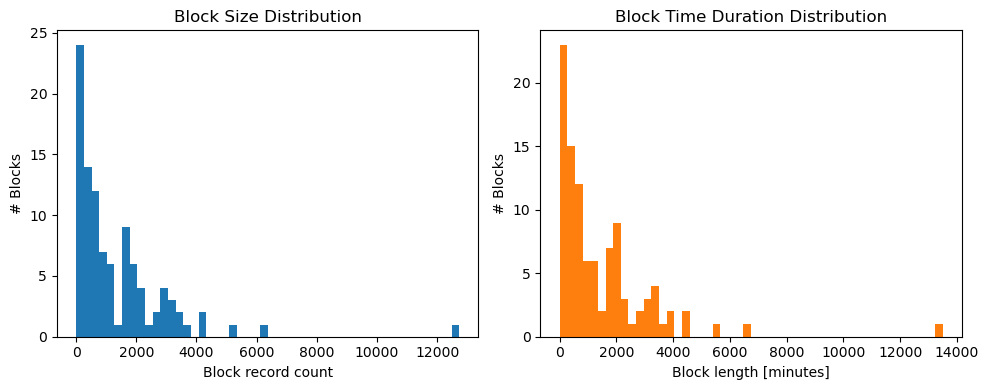

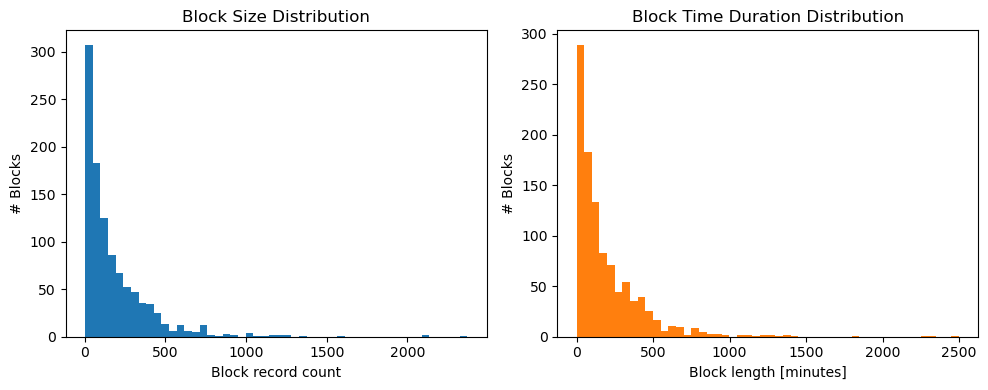

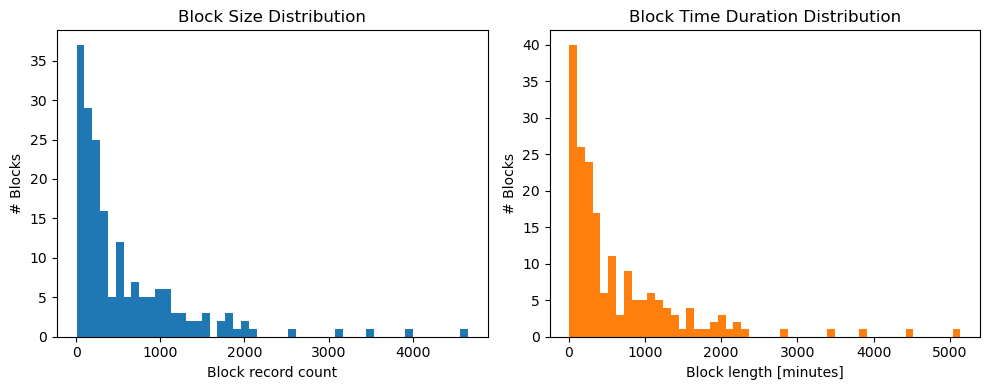

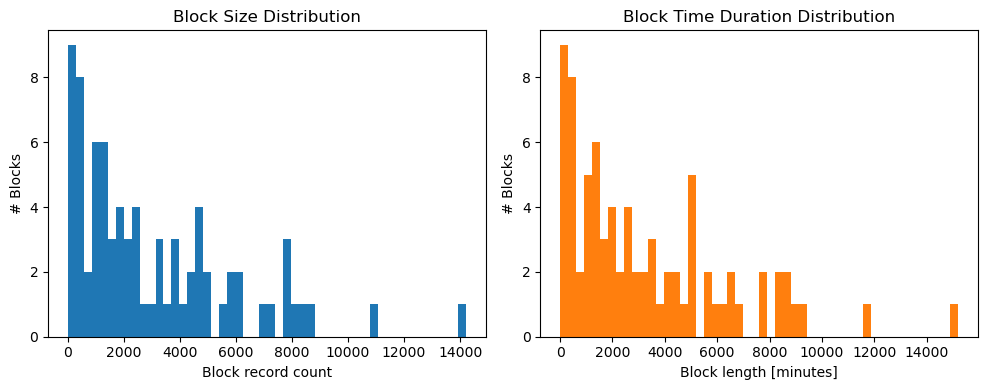

In [34]:
for hw in list_hw:

    print_separator(hw) #function to display a nice line separator with name
    dist_blocks = df_blocks.where(col("hwid")==hw).groupBy("BlockID").agg(count("*").alias("Block count")).orderBy("Block count")
    data = dist_blocks.toPandas()
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(data['Block count'], bins=50)
    axes[0].set_xlabel("Block record count")
    axes[0].set_ylabel("# Blocks")
    axes[0].set_title("Block Size Distribution")

    dist_blocks_min = (
        df_blocks.where(col("hwid") == hw)
        .groupBy("BlockID")
        .agg(((spark_max("when") - spark_min("when"))/60).alias("minutes"))
        .orderBy("minutes")
    )
    data = dist_blocks_min.toPandas()

    axes[1].hist(data['minutes'], bins=50, color = "#ff7f0e")
    axes[1].set_xlabel("Block length [minutes]")
    axes[1].set_ylabel("# Blocks")
    axes[1].set_title("Block Time Duration Distribution")
    

    plt.tight_layout()
    plt.show()

In [35]:
df_all_hw.unpersist()

DataFrame[hwid: string, when: int, A5: int, A9: int, ComError: int, P1: int, P10: double, P15: int, P16: double, P17: double, P18: double, P2: int, P5: double, P6: double, P7: double, P8: double, P9: double, S1: int, S10: int, S100: double, S101: double, S102: double, S106: double, S107: double, S108: double, S109: double, S11: int, S110: double, S112: int, S113: int, S114: int, S115: int, S117: int, S118: int, S122: double, S123: int, S124: double, S125: int, S126: double, S127: int, S128: double, S129: double, S130: int, S137: double, S138: double, S140: double, S143: int, S147: int, S15: int, S151: int, S154: double, S157: double, S158: double, S159: double, S16: int, S163: double, S164: double, S165: double, S166: double, S167: double, S169: int, S17: int, S170: int, S171: int, S172: int, S173: int, S174: int, S175: int, S176: int, S178: double, S179: int, S180: double, S181: int, S183: int, S19: double, S2: int, S201: int, S202: int, S203: int, S204: int, S205: int, S206: int, S25

# 3) Anomaly detection (engines)

Each device in the dataset contains four different engines responsible for compressing gas to either chill or heat the environment. Continuously turning these engines ON and OFF at a high frequency is not recommended and could indicate problems during installation, deterioration of mechanical parts, or unsuitable external environmental conditions.

We define a column __flagAnomaly__ that is 1 when at least one of the four engines is experiencing an anomaly. The function is parallelized on each blockID (independent record between blocks), so we can inspect the anomalies found in the corresponding block. <br> IMPORTANT: This function is highly sensitive to changes in the __time_separator__ and __threshold__ parameters, which respectively define the minimum time gap between two anomalies and the minimum number of switches required to classify an event as anomalous.

## Distributed Analysis for Anomaly Detection

In [36]:
#Loading the saved file
df_blocks = spark.read.parquet("/mnt/shared/df_blocks.parquet/")

df_blocks = df_blocks.withColumn("A5", col("A5").cast("int"))
df_blocks = df_blocks.withColumn("A9", col("A9").cast("int"))

In [37]:
def detect_anomalies(df, time_separator, threshold, sensors, debug=False):

    # Partition data by BlockID. Underlying assumption is that data belonging to different blocks are not related.
    window = Window.partitionBy("BlockID").orderBy("when")

    # Forward-shift sensors'columns by 1 
    lagged_columns = [lag(col(s)).over(window) for s in sensors] 
    lag_names      = [f"lagged_{s}" for s in sensors]
    
    df_lagged = df.withColumns(dict(zip(lag_names, lagged_columns)))

    # Determine if sensors switched (didSwitch = 1 if sensor goes from 1 to 0 or viceversa , didSwitch = 0 otherwise)
    didSwitch    = [when((col(f"lagged_{s}") != col(s)), 1).otherwise(0) for s in sensors] 
    switch_names = [f"didSwitch_{s}" for s in sensors]    

    df_didSwitch = df_lagged.withColumns(dict(zip(switch_names, didSwitch)))

    # Detect switchID: we assign an increasing ID to 'far enough' switching rows (by 'far enough' we mean 'distant at least time_separaor')
    # Notice: switchID is null for non-switching rows
    df_anomalies = df_didSwitch
    for sensor in sensors:   

        # Filter away non-switching rows / switching 1 not preceded by a 'close' 0 / switching 0 not followed by a 'close' 0 
        df_IDs = (
            df_didSwitch \
            .withColumn(f'theres0Before_{sensor}', count_if(col(sensor) == 0).over(window.rangeBetween(1, time_separator)) > 0) \
            .withColumn(f'theres0After_{sensor}', count_if(col(sensor) == 0).over(window.rangeBetween(-time_separator, -1)) > 0) \
            .filter( 
                (col(f'didSwitch_{sensor}') == 1) & 
                (when(col(sensor) == 1, col(f'theres0Before_{sensor}')).otherwise(True)) &
                (when(col(sensor) == 0, col(f'theres0After_{sensor}')).otherwise(True))
            ) \
            .withColumn(f'startGroup_{sensor}', when((col('when')-lag(col('when'), 1, -1e9).over(window))>time_separator, 1).otherwise(0)) \
            .withColumn(f'switchID_{sensor}', spark_sum(col(f'startGroup_{sensor}')).over(window)) \
        )
        
        # Add ID column to initial df
        df_anomalies = df_anomalies.join(
            other = df_IDs.select('BlockID', 'when', f'startGroup_{sensor}', f'switchID_{sensor}'),
            on = ['BlockID', 'when'],
            how = 'left'
        )

    # Count how many rows have the same switchID in each block
    count_names = [f'count_{s}' for s in sensors]
    count_cols  = [count('*').over(Window.partitionBy('BlockID', f'switchID_{s}')) for s in sensors]

    # Determine anomaly flag: if there are more than 'threshold' rows with same ID (i.e. there are 'many' switches in a 'small' time) such row is an anomaly
    flag_names  = [f'flag_{s}' for s in sensors]
    flag_cols   = [when((col(f'count_{s}') >= threshold) & (col(f'switchID_{s}') > 0), True).otherwise(False) for s in sensors]
    
    df_flag = df_anomalies \
        .withColumns(dict(zip(count_names, count_cols))) \
        .withColumns(dict(zip(flag_names, flag_cols))) \
        .orderBy('BlockID', 'when')

    # Extend anomaly period: we classify as anomalies also non-switching rows comprised between equally-indexed anomaly-flagged rows (we expect anomalies to be exteneded-in-time) 
    # 1) Find the closest previous/posterior switchID if there is at least one with True flag anomaly.
    next_w  = Window.partitionBy('BlockID').orderBy('when').rangeBetween(0, time_separator)
    prev_w  = Window.partitionBy('BlockID').orderBy('when').rangeBetween(-time_separator, 0)

    prev_names = [f'prevID_{s}' for s in sensors]
    prev_id = [when((bool_or(f'flag_{s}').over(prev_w)), spark_max(f'switchID_{s}').over(prev_w)).otherwise(None) for s in sensors]
    next_names = [f'nextID_{s}' for s in sensors]
    next_id = [when((bool_or(f'flag_{s}').over(next_w)), spark_min(f'switchID_{s}').over(next_w)).otherwise(None) for s in sensors]

    df_newID = (
        df_flag \
            .withColumns(dict(zip(prev_names, prev_id))) \
            .withColumns(dict(zip(next_names, next_id)))
    )

    # 2) Check if next and previous indices coincide AND they are not 0/null.
    new_flags = [when((col(f'nextID_{s}') == col(f'prevID_{s}')) & (col(f'nextID_{s}') > 0), True).otherwise(col(f'flag_{s}')) for s in sensors]
    
    df_flag = df_newID.withColumns(dict(zip(flag_names, new_flags)))
    
    # Finally determine joint anomaly flag: if at least one of the sensors is anomalous, flag_anomaly=True
    condition = reduce(lambda a, b: a | b, [col(f'flag_{s}') for s in sensors])
    df_flag = df_flag.withColumn('flag_anomaly', when(condition, 1).otherwise(0))

    if debug:
        return df_flag
    else:
        return df_flag.select("BlockID", "when", *sensors, *flag_names, 'flag_anomaly') 

In [38]:
list_df_anomalies = {}
for hw in list_hw:
    df_anomalies = detect_anomalies(
        df_blocks.filter( col("hwid") == hw),
        time_separator = 30*60, # seconds
        threshold = 8,
        sensors = engines
    )

    list_df_anomalies[hw] = df_anomalies

In [39]:
hw_to_inspect = 'SW-088'
list_df_anomalies[hw_to_inspect].filter('flag_S117').show(3, truncate=False)

+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|BlockID|when      |S117|S118|S169|S170|flag_S117|flag_S118|flag_S169|flag_S170|flag_anomaly|
+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|136    |1603453230|1   |1   |1   |0   |true     |false    |true     |false    |1           |
|136    |1603453290|1   |1   |1   |0   |true     |false    |true     |false    |1           |
|136    |1603453350|1   |0   |0   |1   |true     |false    |true     |false    |1           |
+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
only showing top 3 rows



In [40]:
engine_inspect = "S117"

print(f"Know some BlockID where there are anomalies, so we can plot it and see (hw:{hw_to_inspect}, engine:{engine_inspect}).")

BlockWithAnom = list_df_anomalies[hw_to_inspect].filter(f'flag_{engine_inspect}').select('BlockID').distinct().orderBy('BlockID')
BlockWithAnom.show(3)

listBlockAnom = BlockWithAnom.collect()

Know some BlockID where there are anomalies, so we can plot it and see (hw:SW-088, engine:S117).
+-------+
|BlockID|
+-------+
|    136|
|    180|
|    202|
+-------+
only showing top 3 rows



We want to inespect the anomalies detected in some of the blocks in order to understand how they are made (e.g. we will consider hwid: SW-088 and engine: S177). <br> <br>
The plots  below show 
* __ON THE RIGHT__ a specific block where it is shown when the engines is ON (value 1) or OFF (value 0). The orange interval is the interval the algorithm flags as anomaly.

* __ON THE LEFT__ the same block but __Remembering that the number of record in a block usually does not correspond to the time elapsed in a block since there might be empty interval__: the red bars correspond to the empty intervals (where there are no data)

In [41]:
def inspect_anomalies(df_dict, hw, engine, blockID):

    df = df_dict[hw]
    
    def extract_column(df, column, default):
        return df.filter(col('BlockID') == blockID) \
            .select(when(col(column).isNull(), default).otherwise(col(column))) \
            .rdd.flatMap(lambda x: x).collect()
    def extract_when(df):
        return df.filter(col('BlockID') == blockID) \
            .select('when') \
            .rdd.flatMap(lambda x: x).collect()

    values    = extract_column(df, engine, 0)
    anomalies = extract_column(df, f'flag_{engine}', False)
    whens     = extract_when(df)

    display(HTML(f"""
    <div style="font-family: monospace; padding: 10px; text-align: center;">
    -------------------------- HW: {hw} --- Engine: {engine} --------------------------
    </div>
    """))
    
    fig, axes = plt.subplots(1, 2, figsize=(14,5))

    t_min, t_max = min(whens), max(whens)
    full_t = list(range(t_min, t_max + 60, 60))
    full_t_rel = [(t - t_min) // 60 for t in full_t]
    whens_rel  = [(w - t_min) // 60 for w in whens]
    values_map    = dict(zip(whens_rel, values))
    anomalies_map = dict(zip(whens_rel, anomalies))
    aligned_values    = [values_map.get(t, 0) for t in full_t_rel]
    aligned_anomalies = [anomalies_map.get(t, 0) for t in full_t_rel]
    missing = [0.5 if t not in whens_rel else 0 for t in full_t_rel]
    combined_anomalies = [max(a, m) for a, m in zip(aligned_anomalies, missing)]

    axes[0].bar(full_t_rel, aligned_values, width=1, alpha=0.7, label=engine)
    axes[0].bar(full_t_rel, combined_anomalies, width=1, alpha=0.5, label="anomal")
    axes[0].bar(full_t_rel, missing, width=1, alpha=0.8, color="red", label="time gaps", zorder = 100)
    axes[0].set_xlabel("Minutes (relative to block start)")
    axes[0].set_ylabel(engine)
    axes[0].legend(loc="upper right")
    axes[0].set_title(f"Block N.{blockID} (raw)")

    t = range(len(anomalies))
    axes[1].bar(t, values, width=1, alpha=0.5, lw=1, label=engine)
    axes[1].bar(t, anomalies, width=1, alpha=0.5, label="anomal")
    axes[1].set_xlabel("Consecutive available data")
    axes[1].set_ylabel(engine)
    axes[1].legend(loc="upper right")
    axes[1].set_title(f"Block N.{blockID} (aligned)")

    plt.tight_layout()
    plt.show()

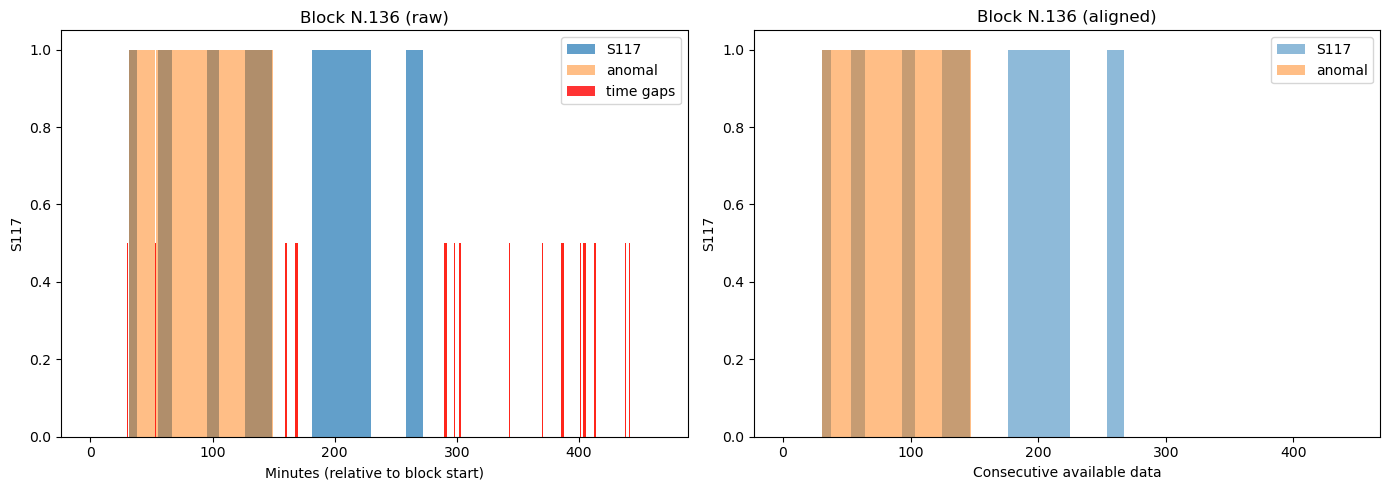

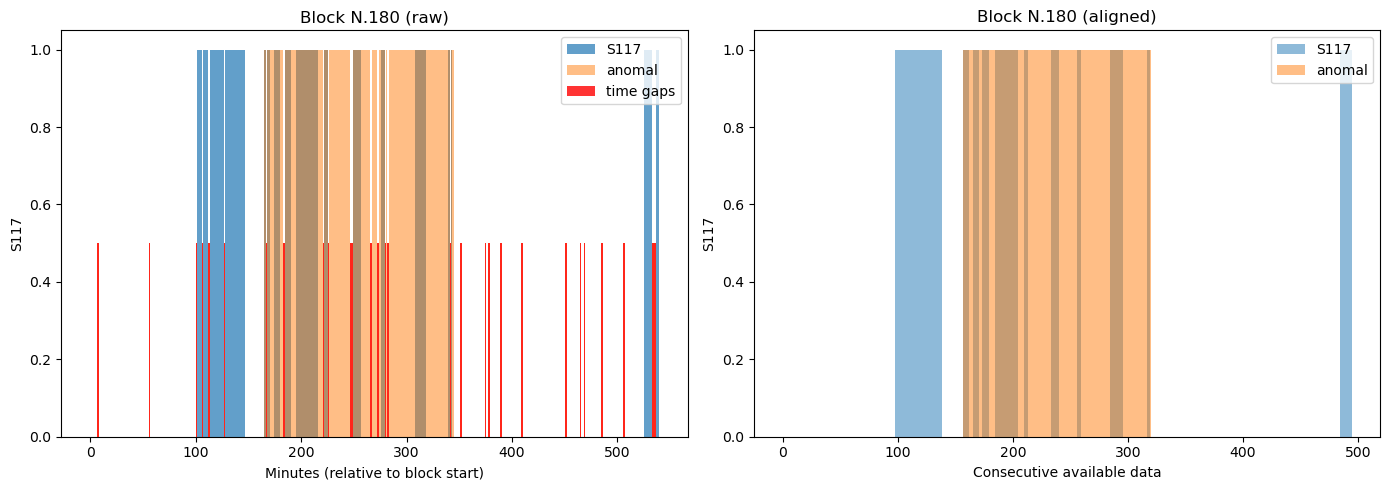

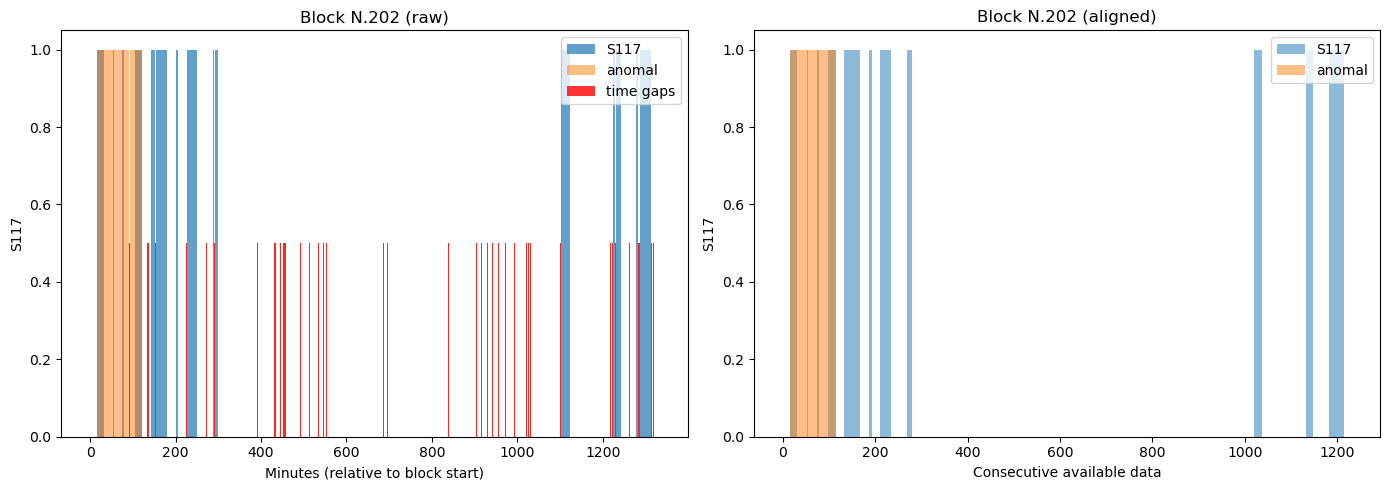

In [42]:
for row in listBlockAnom[:3]:
    inspect_anomalies(list_df_anomalies, hw_to_inspect, engine_inspect, row[0])

In [43]:
# Join on 'when' and take just 'flag_anomaly'

list_df_blocks_anom = {}

for hw in list_hw:
    df_anom = list_df_anomalies[hw].select('when', 'flag_anomaly')
    list_df_blocks_anom[hw] = df_blocks.filter( col("hwid") == hw ).join( df_anom, on='when', how='left' )

## Linear correlation setup

Computing the covariance matrix of the metrics using the already implemented __computeCovariance()__ function. This setup will serve as a foundation for all upcoming sections.

In [44]:
def compute_covariance_matrix(df, cols=None):

    if cols is None:
        cols = df.columns

    for c in cols:
        df = df.withColumn(c, col(c).cast(DoubleType()))

    df = df.na.drop(subset=cols)

    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    df_vec = assembler.transform(df).select("features")

    rows = df_vec.rdd.map(lambda row: MLLibVectors.dense(row.features.toArray()))

    mat = RowMatrix(rows)

    cov_matrix = mat.computeCovariance().toArray()

    return cov_matrix, cols

In [45]:
cov_matrix_anom = {}

for hw in list_hw:
    cov_matrix_anom[hw], used_cols = compute_covariance_matrix(list_df_blocks_anom[hw], [*useful_sensors, "flag_anomaly"])

In [46]:
def correlations(cov_matrix, sensors_list, target_col):
    # Find index of the target column
    index = sensors_list.index(target_col)

    # Standard deviations from covariance matrix (sqrt of diagonal elements)
    std_devs = np.sqrt(np.diag(cov_matrix))
    
    # Compute correlations for target_col
    correlations = cov_matrix[index] / (std_devs[index] * std_devs)
    
    # Build DataFrame
    results_df = pd.DataFrame({
        "Sensors": sensors_list,
        "Correlations": correlations})
    
    # Drop self-correlation (the diagonal)
    results_df = results_df[results_df["Sensors"] != target_col]
    
    # Drop NaN and Inf
    results_df = results_df.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Sort by absolute correlation (highest first)
    sorted_results = results_df.sort_values(by="Correlations", key=lambda x: abs(x), ascending=False)
    
    return sorted_results


In [47]:
def plot_correlations(df_spark, target_col, feature_cols, corr_df, hw):
    pd_df = df_spark.select(target_col, *feature_cols).toPandas()
    
    for feature in feature_cols:
        corr_val = corr_df[corr_df["Sensors"] == feature]["Correlations"].values
        corr_str = f"{corr_val[0]:.3f}" if len(corr_val) > 0 else "N/A"
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Create histograms and extract bin data
        hist_info = {}
        for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
            subset = pd_df[pd_df[target_col] == target_val]
            count_data = len(subset)
            n, bins, patches = ax2.hist(subset[feature], bins=30, alpha=0.5, color=color, 
                                      label=f"{target_col}={target_val}\n({count_data} data)", density=True)
            hist_info[target_val] = {'counts': n, 'bins': bins}
        
        ax2.set_ylabel("Density")
        ax2.legend()
        
        # Calculate intersection percentage
        bin_width = hist_info[0]['bins'][1] - hist_info[0]['bins'][0]
        intersection_area = np.sum(np.minimum(hist_info[0]['counts'], hist_info[1]['counts'])) * bin_width
        inter = intersection_area * 100
        
        # Scaling parameters for scatter
        all_counts = np.concatenate([hist_info[0]['counts'], hist_info[1]['counts']])
        max_count = np.max(all_counts)
        min_count = np.min(all_counts[all_counts > 0])
        min_alpha, max_alpha = 0.01, 1.0
        min_size, max_size = 1, 50
        
        # Create scatter plot with density-based styling
        for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
            subset = pd_df[pd_df[target_col] == target_val]
            subset = subset.sample(frac=0.1)
            
            bin_indices = np.digitize(subset[feature], hist_info[target_val]['bins']) - 1
            bin_indices = np.clip(bin_indices, 0, len(hist_info[target_val]['counts']) - 1)
            point_counts = hist_info[target_val]['counts'][bin_indices]
            
            if max_count == min_count:
                alphas = np.full_like(point_counts, (min_alpha + max_alpha) / 2)
                sizes = np.full_like(point_counts, (min_size + max_size) / 2)
            else:
                alphas = min_alpha + ((point_counts - min_count) / (max_count - min_count)) * (max_alpha - min_alpha)
                sizes = min_size + ((point_counts - min_count) / (max_count - min_count)) * (max_size - min_size)
            
            ax1.scatter(subset[feature], subset[target_col], color=color, alpha=alphas, s=sizes, marker='o')
        
        ax1.set_ylabel(target_col)
        fig.suptitle(f"HW: {hw} - Sensor: {feature} - Correlation: {corr_str} - Intersection: {inter:.1f}%")
        plt.tight_layout()
        plt.show()

## Correlation Analysis for Anomalies

Showing the most anomaly-correlated distribution among all metrics. <br>
It is worth noting that on the 2anomalous side" occasionally the overlapping region exhibits a small bump, resembling a localized accumulation, which may indicate that the chosen hyperparameters for anomaly detection are not the optima ones in separating the two distributions.

/tmp/ipykernel_2422624/856096306.py:9: RuntimeWarning: divide by zero encountered in divide
  correlations = cov_matrix[index] / (std_devs[index] * std_devs)
/tmp/ipykernel_2422624/856096306.py:9: RuntimeWarning: invalid value encountered in divide
  correlations = cov_matrix[index] / (std_devs[index] * std_devs)
                                                                                

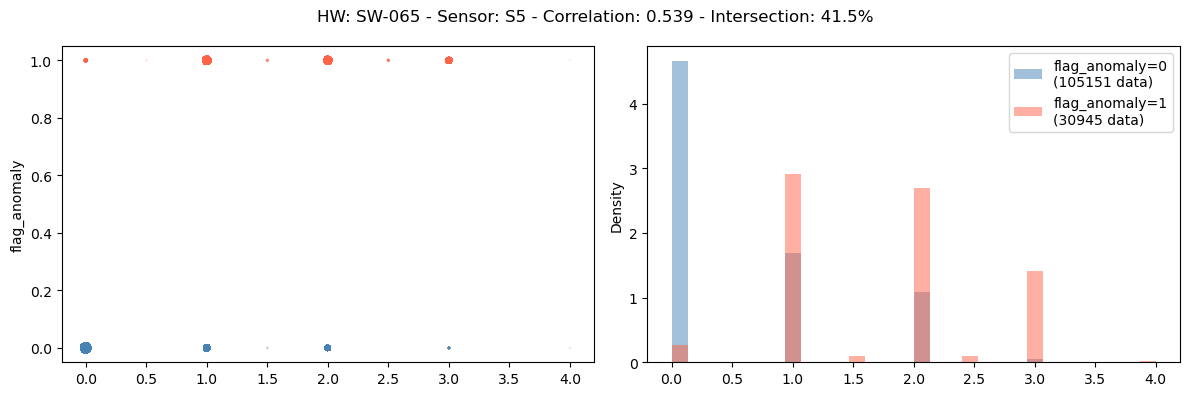

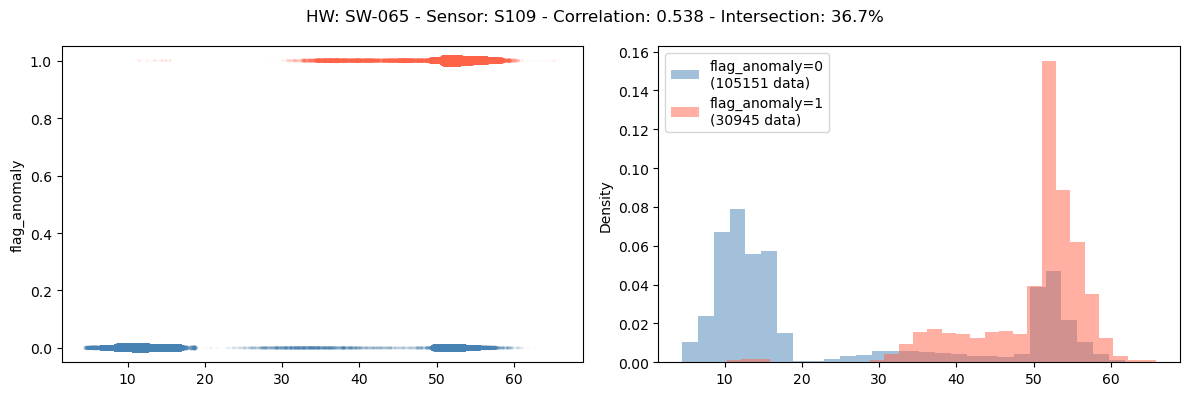

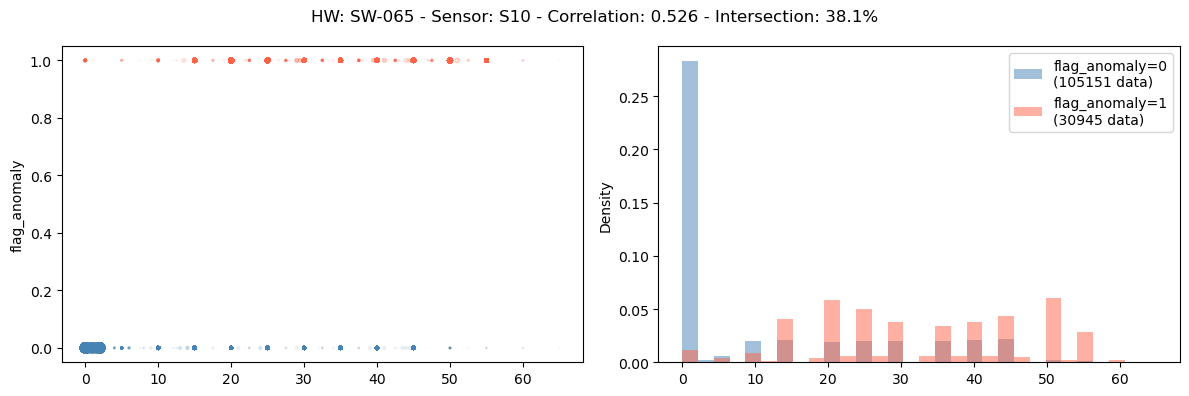

/tmp/ipykernel_2422624/856096306.py:9: RuntimeWarning: invalid value encountered in divide
  correlations = cov_matrix[index] / (std_devs[index] * std_devs)
                                                                                

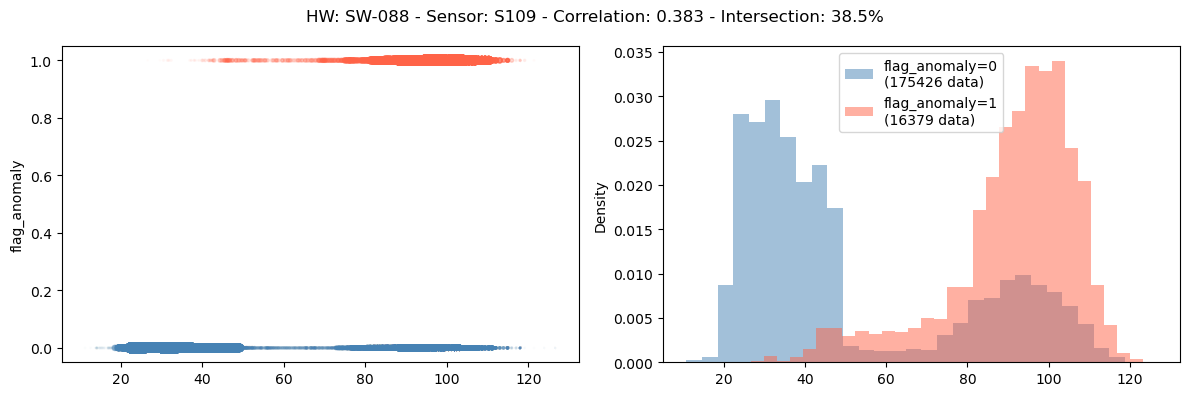

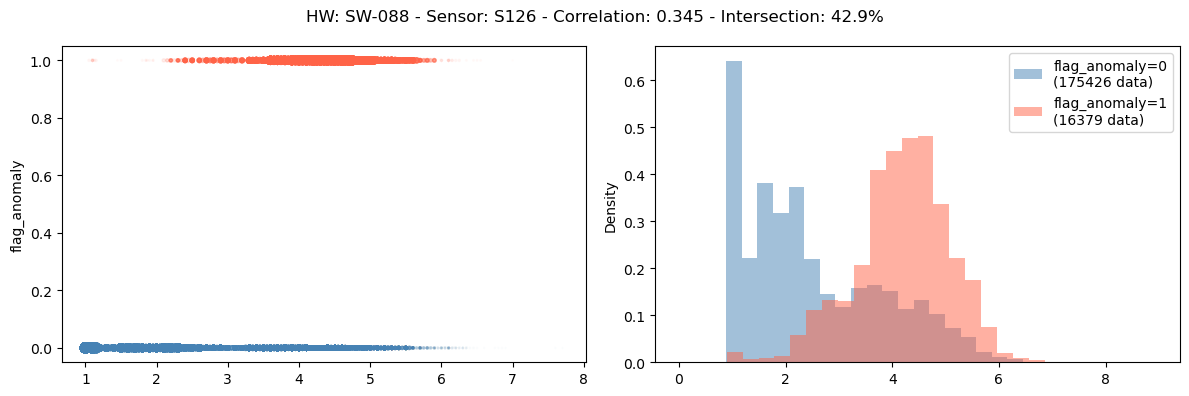

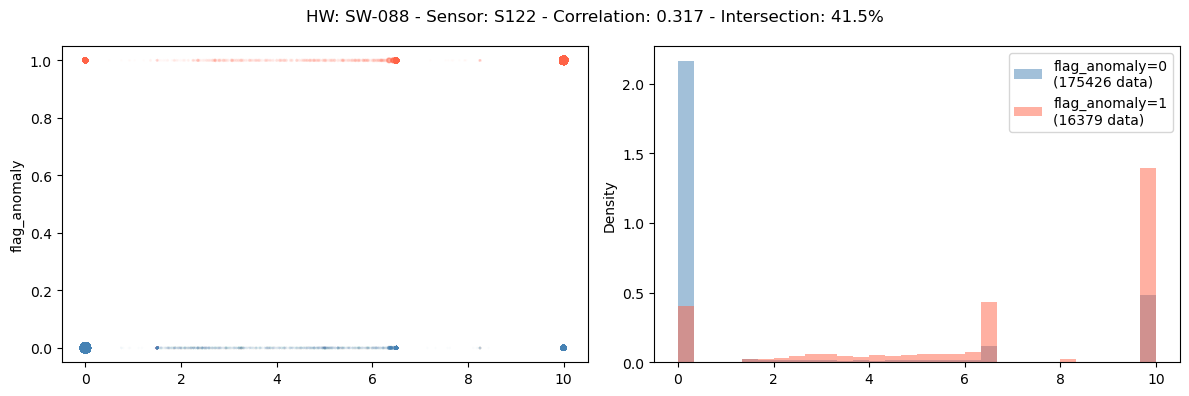

/tmp/ipykernel_2422624/856096306.py:9: RuntimeWarning: invalid value encountered in divide
  correlations = cov_matrix[index] / (std_devs[index] * std_devs)


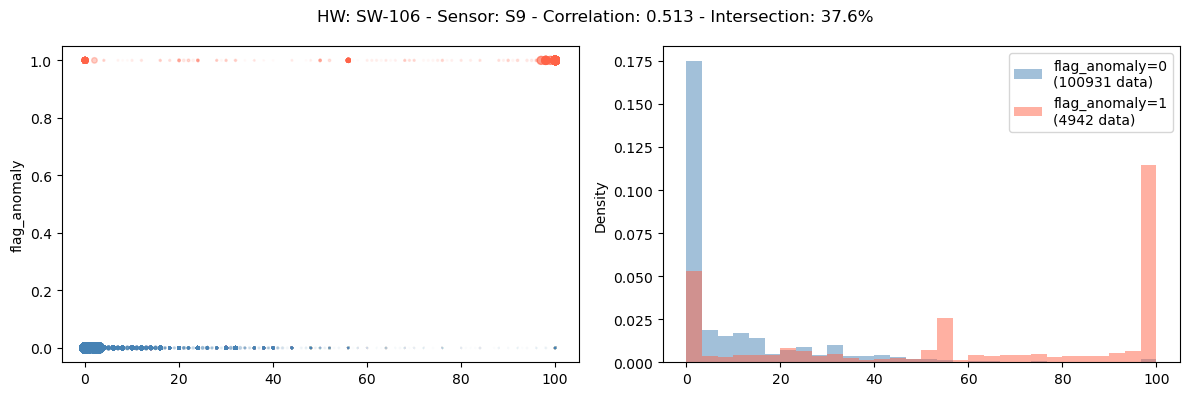

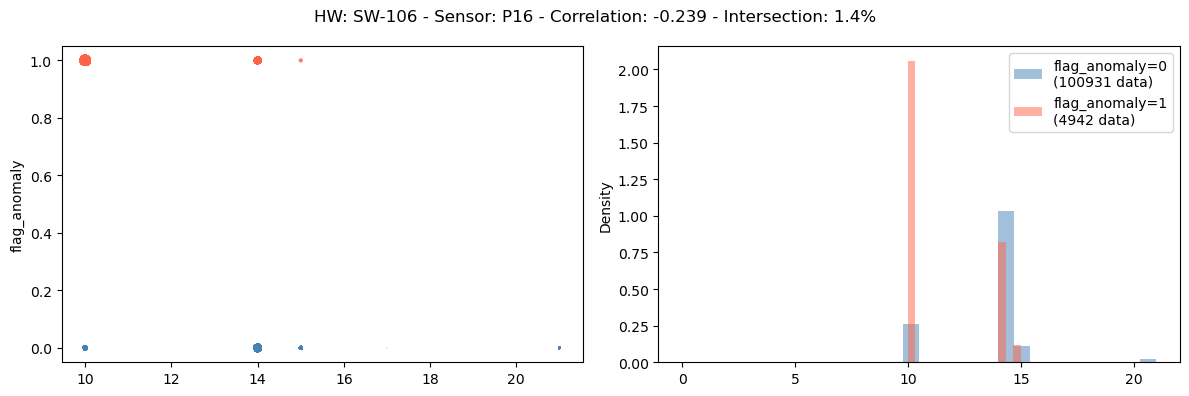

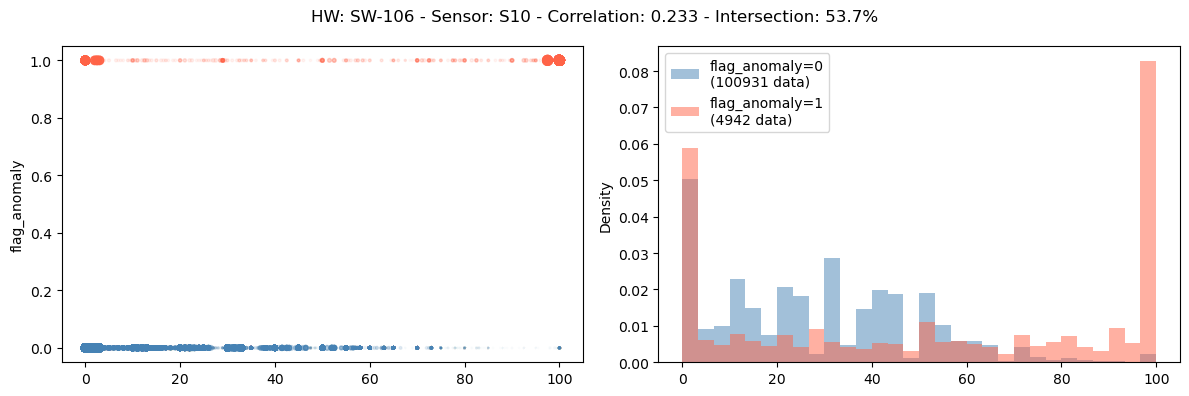

/tmp/ipykernel_2422624/856096306.py:9: RuntimeWarning: invalid value encountered in divide
  correlations = cov_matrix[index] / (std_devs[index] * std_devs)
                                                                                

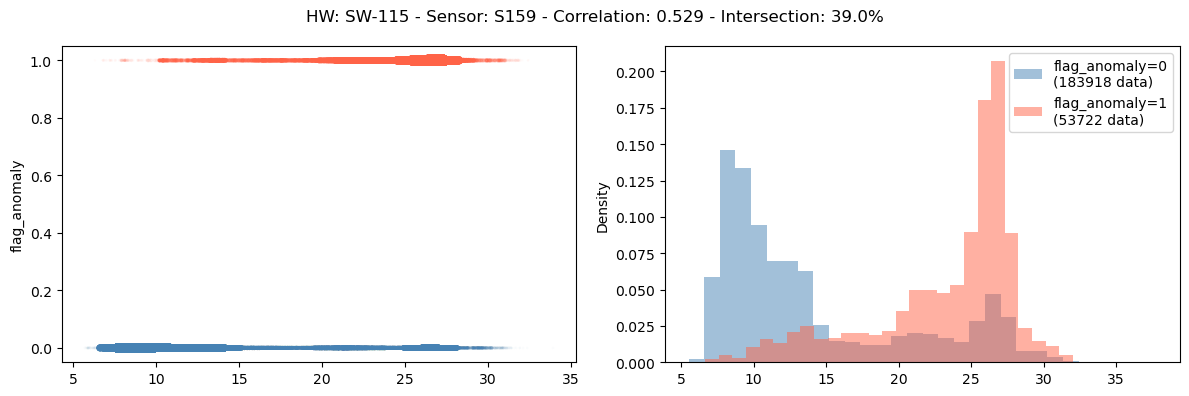

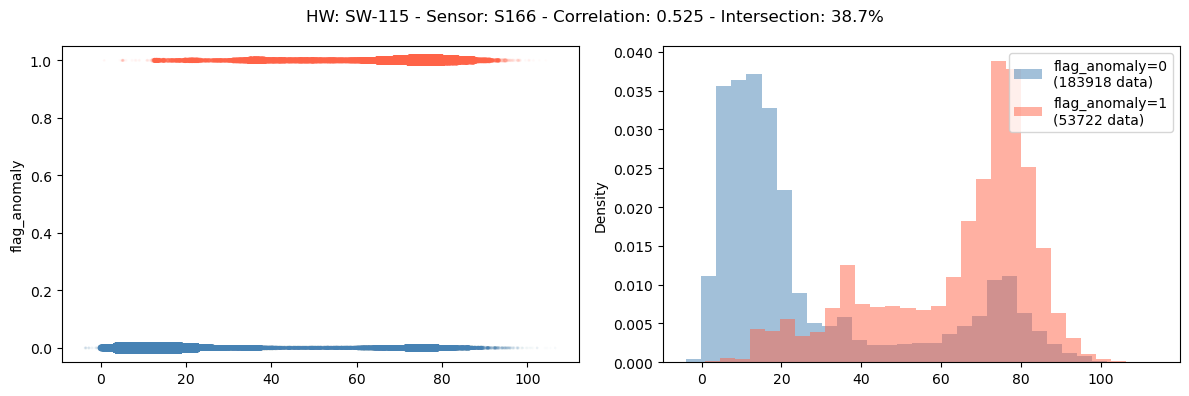

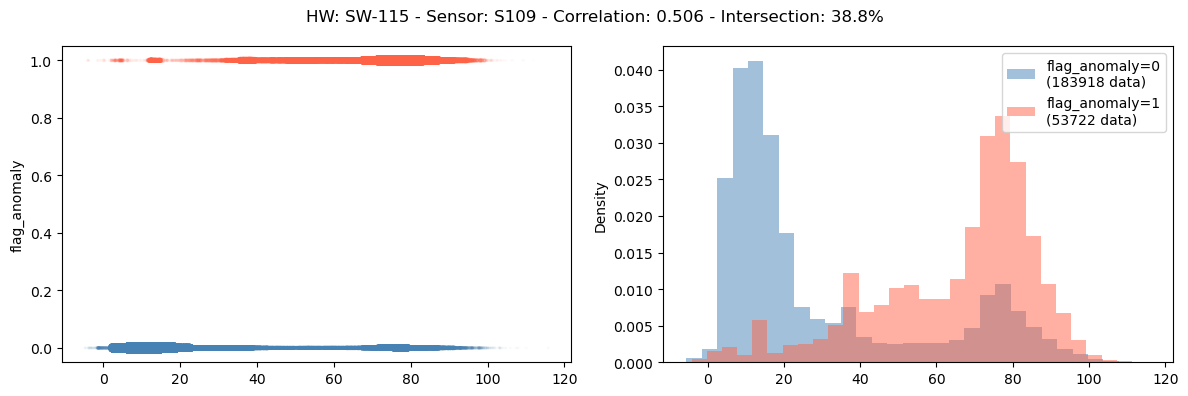

In [48]:
for hw in list_hw:

    print_separator(hw)
    anomaly_corr = correlations(cov_matrix_anom[hw], used_cols, 'flag_anomaly')
    top_anom_corr = anomaly_corr.head(3)['Sensors'].tolist()
    plot_correlations(list_df_blocks_anom[hw], 'flag_anomaly', top_anom_corr, anomaly_corr, hw)

# 4) Anomaly detection (temperature)

Each device in the dataset contains four different engines. The percentage of working/loading of these units is crucial as it can indicate issues related to under-dimensioned or over-dimensioned devices, deterioration of mechanical parts, or unsuitable external environmental conditions. <br> Here we identify possible correlations between the percentage of device loading (__S125__, __S181__) and the external temperature (__S41__). 

## Correlation between device load and external temperature (S125-S181 vs S41)

Showing the joint distribution of temperature (__S41__) and percentage work load (__S125__, __S181__).

We observe, for most of the hardware units, a trend consistent with the thermodynamic behavior of heat pumps during winter (dataset spans from October to March): as the average external temperature increases, the workload decreases. Conversely, when the external temperature drops, the machines require greater effort to ensure adequate heating. <br> Based on this pattern and the available sensor types, we can reasonably infer that the dataset refers to an industrial water-to-water heat pump system.

/tmp/ipykernel_2422624/856096306.py:9: RuntimeWarning: divide by zero encountered in divide
  correlations = cov_matrix[index] / (std_devs[index] * std_devs)
/tmp/ipykernel_2422624/856096306.py:9: RuntimeWarning: invalid value encountered in divide
  correlations = cov_matrix[index] / (std_devs[index] * std_devs)


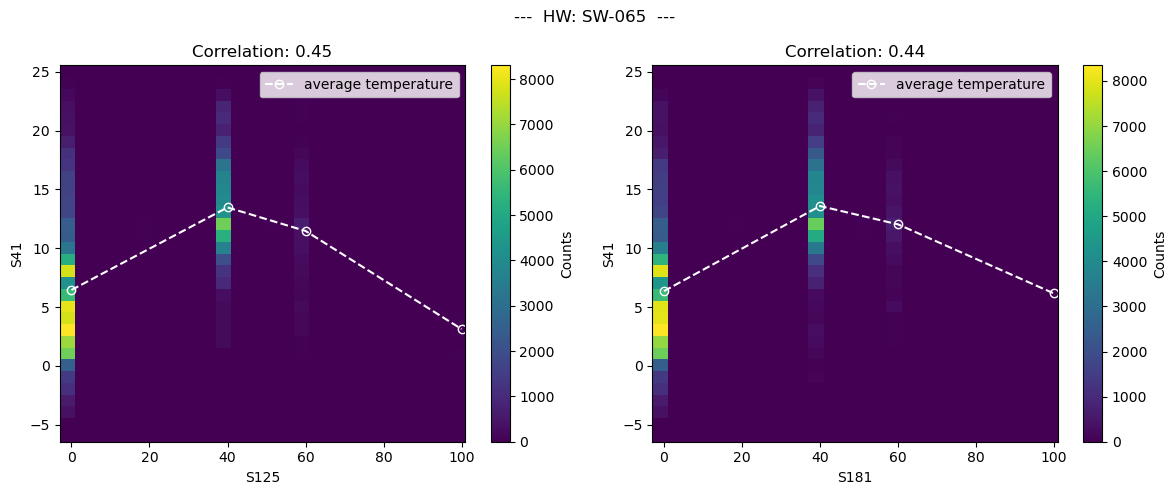

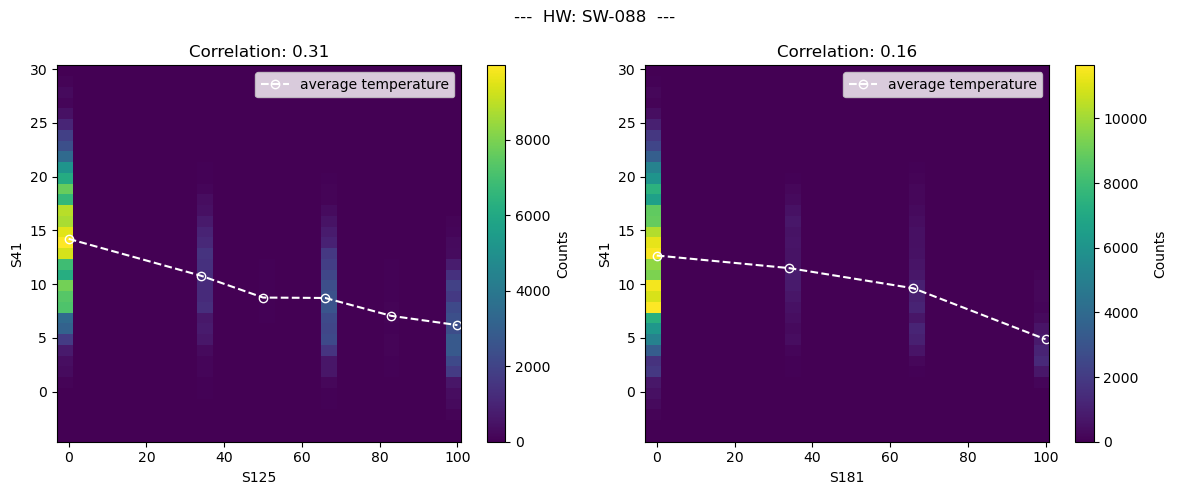

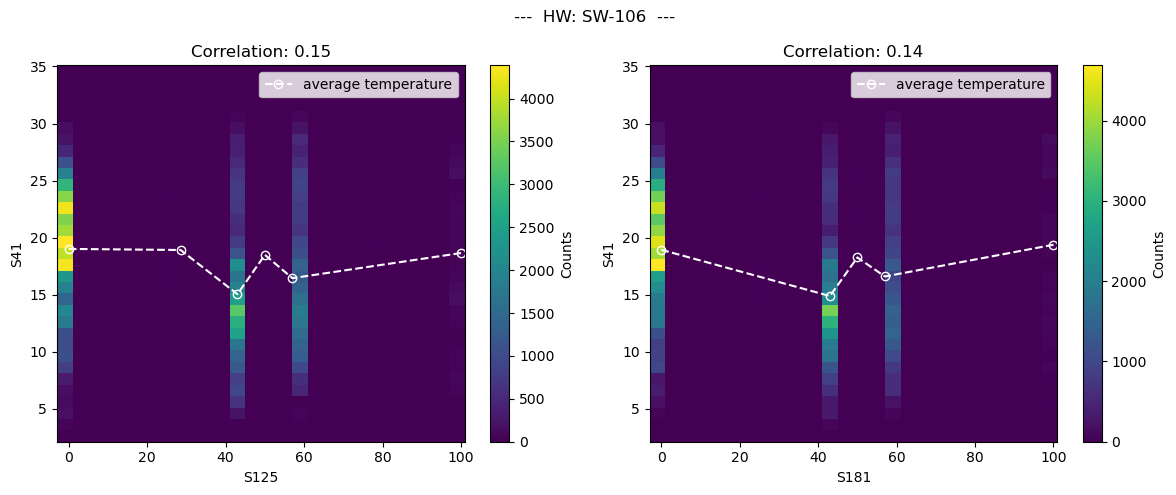

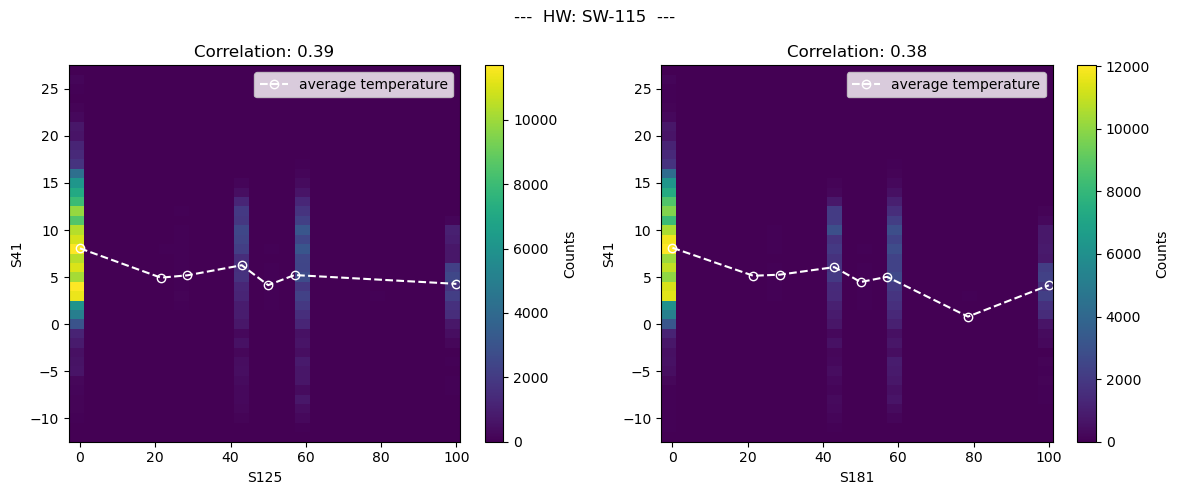

In [49]:
load_sensors = ['S125', 'S181']
temperature_sensor = 'S41'

def extract_col(df, colName): return df.select(colName).rdd.flatMap(lambda x: x).collect()

for hw in list_hw:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    # fig.subplots_adjust(wspace=0.4)
    fig.suptitle(f"---  HW: {hw}  ---")

    anomaly_corr = correlations(cov_matrix_anom[hw], used_cols, 'flag_anomaly')
    
    for i in range(len(load_sensors)):
        load_sensor = load_sensors[i]
        filtered_df = list_df_blocks_anom[hw].dropna(subset=(temperature_sensor, load_sensor))
        

        # Plot 2D histogram of (temperature, work-load)
        temperature = extract_col(filtered_df, temperature_sensor)
        load        = extract_col(filtered_df, load_sensor)

        temp_bin_width = 1
        load_bin_width = 4
        min_temp, max_temp = np.min(temperature)-1, np.max(temperature)+1
        min_load, max_load = -1, 101
        temp_bins = np.arange(min_temp - temp_bin_width/2, max_temp + temp_bin_width/2, step=temp_bin_width)
        load_bins = np.arange(min_load - load_bin_width/2, max_load + load_bin_width/2, step=load_bin_width)
        
        counts, xedges, yedges, im = ax[i].hist2d(load, temperature, bins=[load_bins, temp_bins])
        cbar = fig.colorbar(im, ax=ax[i])   
        cbar.set_label('Counts')  
        ax[i].set_ylabel(temperature_sensor)
        ax[i].set_xlabel(load_sensor)
        
        # Plot average temperature over work-load
        avg_temp = 'average temperature'
        averaged_df   = filtered_df \
            .groupBy(load_sensor) \
            .agg(
                count(temperature_sensor).alias('count'),
                spark_avg(temperature_sensor).alias(avg_temp),
                spark_stddev(temperature_sensor).alias('temperature STD')
            ) \
            .filter((col('count') > 300) | (col(load_sensor)==100)) 
        unique_load   = extract_col(averaged_df, load_sensor) 
        averaged_temp = extract_col(averaged_df, avg_temp) 
        
        sorting = np.argsort(unique_load)
        unique_load = [unique_load[idx] for idx in sorting]
        averaged_temp = [averaged_temp[idx] for idx in sorting]
        
        ax[i].plot(unique_load, averaged_temp, label=avg_temp, color='white', linestyle='--', marker='o', markerfacecolor='none')
        ax[i].legend()    
        ax[i].set_title(f'Correlation: {np.round(anomaly_corr[anomaly_corr['Sensors'] == load_sensor]['Correlations'].tolist()[0], 2)}')
        
    plt.tight_layout()    
    plt.show()

We can make more evident the foretold trend by slicing the above 2D histogram along the x-direction (i.e. by plotting the temperature values correlated to each load percentage). In most of the hardwares we observe again a negative correlation bewteen the average external temperature and the workload of the pump. <br>
The following plots show only the three temperature distributions that have the greatest amount of data.

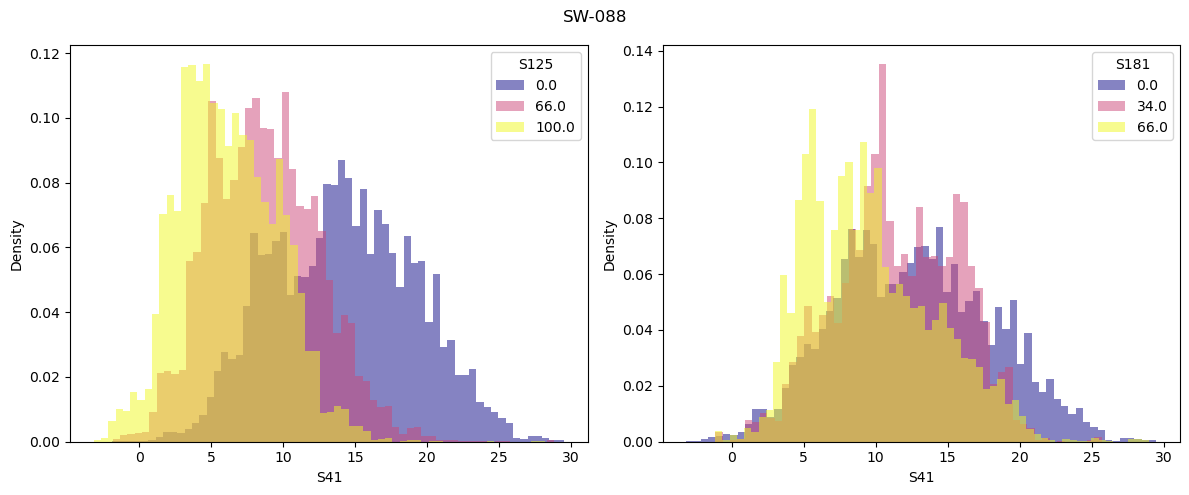

In [50]:
n_distributions = 3 # Show the first n most numerous distributions

hw = 'SW-088'

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"{hw}")

for i in range(len(load_sensors)):

    load_sensor = load_sensors[i]
    noNull_df = list_df_blocks_anom[hw].dropna(subset=(temperature_sensor, load_sensor))

    top_load_percentages = noNull_df \
        .select(load_sensor) \
        .groupBy(load_sensor) \
        .count() \
        .sort('count', ascending=False) \
        .limit(n_distributions) \
        .select(load_sensor) \
        .rdd.flatMap(lambda x: x) \
        .collect()
    
    cmap = plt.get_cmap('plasma') # viridis, plasma
    colors = [cmap(i) for i in np.linspace(0, 1, n_distributions)]

    for load_percentage, color in zip(sorted(top_load_percentages), colors): 
        temperature = noNull_df \
            .filter(f'{load_sensor} = {load_percentage}') \
            .select(temperature_sensor) \
            .rdd.flatMap(lambda x: x) \
            .collect()
        # bins = int(np.sqrt(len(temperature))/2)
        bins = int(np.max(temperature) - np.min(temperature))*2
        
        ax[i].hist(temperature, bins=bins, color=color, alpha=0.5, label=f'{load_percentage}', density=True)  
        ax[i].set_xlabel(temperature_sensor)
        ax[i].set_ylabel('Density')
        ax[i].legend(title=load_sensor)
        
plt.tight_layout()    
plt.show()

# 5) Predictive maintenance

This section aims to build a model using simple machine learning techniques and specific adjustments to predict—and ideally prevent—overheating alerts. <br> The process begins by analyzing data related to A5 and A9 alarms.

## Conversion of Alarms (A5, A9)

Variables A5 and A9 contain alarms related to the devices. <br>
Specifically, if one or more of the bits in positions 6, 7, and 8 of either or both alarms are equal to 1, it indicates a fault. If at least one of these bits is set to 1, it signifies that the engines are overheating.

Among the four hardware units, only SW-088 recorded overheating signals (124), some of which occurred consecutively or within short intervals as we will see in the following parts, likely indicating repeated alerts for the same issue.

In [51]:
def extract_alarms(df):

    columns=["A5", "A9"]
    bits=[6, 7, 8]
    
    for col_name in columns:
        for bit in bits:
            convert_bit = bit - 1  # bit 1 is LSB
            df = df.withColumn( f"{bit}-{col_name}", ((col(col_name).bitwiseAND(1 << convert_bit)) > 0).cast("int") )

    df = df.withColumn(
        "overheating",
        when((col("6-A5") == 1) | (col("7-A5") == 1) | (col("8-A5") == 1) | (col("6-A9") == 1) | (col("7-A9") == 1) | (col("8-A9") == 1) ,
            1).otherwise(0).cast("int")
            ).where( (col("A5").isNotNull()) | (col("A9").isNotNull()) )
    
    return df

In [52]:
# Extract bits from alarms

list_df_alarms = {}
for hw in list_hw:
    df_alarms = extract_alarms( df_blocks.filter( col("hwid") == hw).select("when","A5","A9") )

    list_df_alarms[hw] = df_alarms
    print( f"For hardware {hw} were recorded {df_alarms.agg(spark_sum(col('overheating'))).collect()[0][0]} overheating signals." )

print("\n")
list_df_alarms['SW-088'].where( col("overheating") == 1 ).orderBy("when").show(6)

For hardware SW-065 were recorded 0 overheating signals.
For hardware SW-088 were recorded 124 overheating signals.
For hardware SW-106 were recorded 0 overheating signals.
For hardware SW-115 were recorded 0 overheating signals.


+----------+-----+----+----+----+----+----+----+----+-----------+
|      when|   A5|  A9|6-A5|7-A5|8-A5|6-A9|7-A9|8-A9|overheating|
+----------+-----+----+----+----+----+----+----+----+-----------+
|1601510790|18496|   0|   0|   1|   0|   0|   0|   0|          1|
|1601510850|18496|NULL|   0|   1|   0|NULL|NULL|NULL|          1|
|1601597190|18496|   0|   0|   1|   0|   0|   0|   0|          1|
|1601597250|18496|NULL|   0|   1|   0|NULL|NULL|NULL|          1|
|1601686290|18496|   0|   0|   1|   0|   0|   0|   0|          1|
|1601686350|18496|NULL|   0|   1|   0|NULL|NULL|NULL|          1|
+----------+-----+----+----+----+----+----+----+----+-----------+
only showing top 6 rows



In [53]:
list_df_final = {}

for hw in list_hw:
    df_final = list_df_blocks_anom[hw].join( list_df_alarms[hw].select('when', 'overheating') , on='when', how='left' )
    list_df_final[hw] = df_final

## Correlation analysis for alarms

In this case, the correlations are very poor. First of all, the overheating signals amount to only 124 entries, a negligible fraction of the entire dataset. <br> Moreover, as will become evident later on, it is extremely challenging to extract a distinct behavioral pattern from the sensors that clearly differentiates overheating conditions from normal operation.

In [54]:
# the only one in which there is overheating
df_final_088 = list_df_final['SW-088']

# fill the null in "overheating" with 0 - normal class
df_final_088 = df_final_088.withColumn("overheating", coalesce(col("overheating"), lit(0)))

cov_matrix_alarms, used_cols = compute_covariance_matrix(df_final_088, [*useful_sensors, "overheating"])

/tmp/ipykernel_2422624/856096306.py:9: RuntimeWarning: invalid value encountered in divide
  correlations = cov_matrix[index] / (std_devs[index] * std_devs)


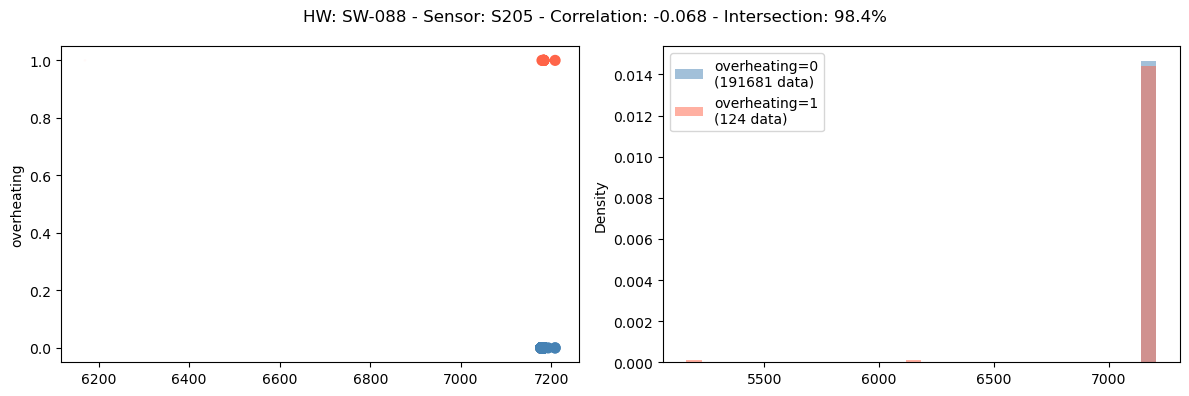

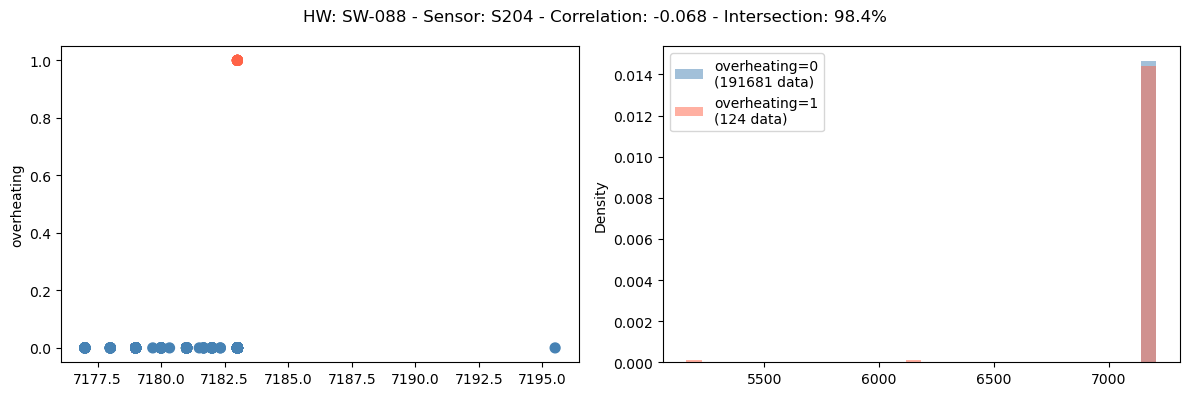

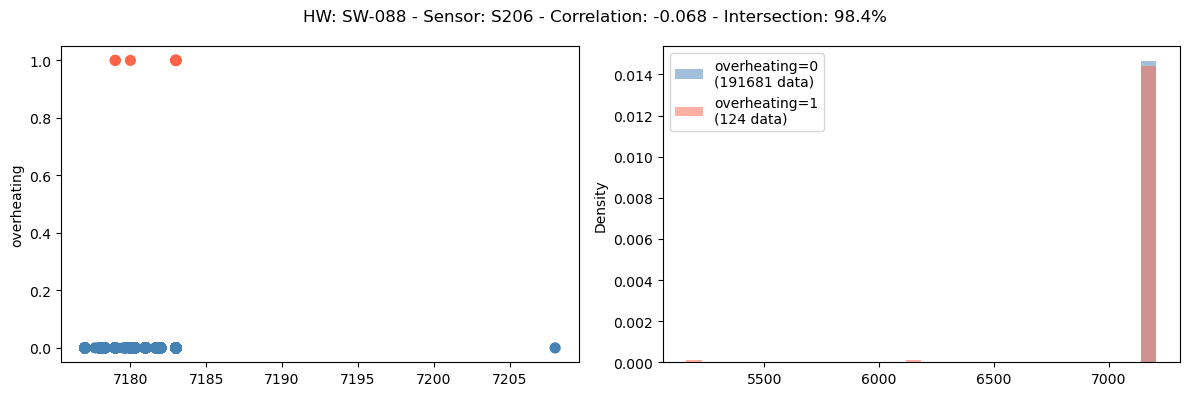

In [55]:
alarm_corr = correlations(cov_matrix_alarms, [*useful_sensors, "overheating"],"overheating")
top_alarm_corr = alarm_corr.head(3)['Sensors'].tolist()

plot_correlations(df_final_088, 'overheating', top_alarm_corr, alarm_corr, 'SW-088')

## Add predictive flag

A new column named __predictive_overheating__ is added for predictive maintenance, flagging with 1 all data points within 30 minutes prior to an overheating signal (note that this structure can also be applied to anomaly-related flags). The 30-minute threshold is arbitrary and considered a tunable hyperparameter.

In [56]:
def add_predictive(df, target, window_before=30, join=True ,debug=False): #window_before in minutes

    w = Window.partitionBy("BlockID").orderBy("when")

    df_pred = df.select("BlockID","when","window_start",target)
    df_pred = df.withColumn(f"prev_{target}", lag(target).over(w))
    df_pred = df_pred.withColumn(
        f"is_start_{target}",
        when(
            (col(target) == 1) &
            ((col(f"prev_{target}") != 1) | col(f"prev_{target}").isNull()),
            1
        ).otherwise(0)
    )

    df_pred = df_pred.withColumn(f"start_time_{target}", when(col(f"is_start_{target}") == 1, col("when")))

    w_future = w.rowsBetween(Window.currentRow, Window.unboundedFollowing)
    df_pred = df_pred.withColumn(
        f"next_start_{target}",
        first(f"start_time_{target}", ignorenulls=True).over(w_future)
    )

    window_seconds = window_before * 60
    df_pred = df_pred.withColumn(
    f"predictive_{target}",
        when(
            (col(f"next_start_{target}").isNotNull()) &
            (((col(target).isNull()) | (col(target) == 0))) &
            ((col(f"next_start_{target}") - col("when")) > 0) &
            ((col(f"next_start_{target}") - col("when")) <= window_seconds), 1 ).otherwise(0))

    if not debug:
        df_pred = df_pred.select("BlockID","when",target,f"predictive_{target}")


    if join:
        return df.join( df_pred.select('when', f'predictive_{target}') , on='when', how='left' )
    else:
        return df_pred

In [57]:
# adding predicting flag both for overheating and for anomaly (just for illustrations anomaly)

target = "overheating"
df_final_088 = add_predictive(df_final_088, target, window_before=30, debug=False, join=True )

target = "flag_anomaly"
df_final_088 = add_predictive(df_final_088, target, window_before=30, debug=False, join=True )

In [58]:
# Example of "predictive flag"

target = "overheating"
df_final_088.where( (col("when") >= 1611963630) & (col("when") <= 1611965670) ).orderBy(col("when").asc()) \
     .select("when","window_start",target,f"predictive_{target}") .show(50)

+----------+-------------------+-----------+----------------------+
|      when|       window_start|overheating|predictive_overheating|
+----------+-------------------+-----------+----------------------+
|1611963630|2021-01-29 23:40:00|          0|                     0|
|1611963690|2021-01-29 23:41:00|          0|                     0|
|1611963750|2021-01-29 23:42:00|          0|                     1|
|1611963810|2021-01-29 23:43:00|          0|                     1|
|1611963870|2021-01-29 23:44:00|          0|                     1|
|1611963930|2021-01-29 23:45:00|          0|                     1|
|1611963990|2021-01-29 23:46:00|          0|                     1|
|1611964050|2021-01-29 23:47:00|          0|                     1|
|1611964110|2021-01-29 23:48:00|          0|                     1|
|1611964170|2021-01-29 23:49:00|          0|                     1|
|1611964230|2021-01-29 23:50:00|          0|                     1|
|1611964290|2021-01-29 23:51:00|          0|    

However, recomputing correlations between data points preceding overheating events and the full dataset yields more promising results than those obtained using only the overheating signals (similar correlations were without filling null in the overheating signals). This opens up the possibility of implementing a predictive model. <br> Again it's important to note the strong class imbalance, with the dataset being overwhelmingly composed of data labeled as 'normal'.

In [59]:
cov_matrix_pred_alarms, used_cols = compute_covariance_matrix(df_final_088, [*useful_sensors, "predictive_overheating"])

/tmp/ipykernel_2422624/856096306.py:9: RuntimeWarning: invalid value encountered in divide
  correlations = cov_matrix[index] / (std_devs[index] * std_devs)
                                                                                

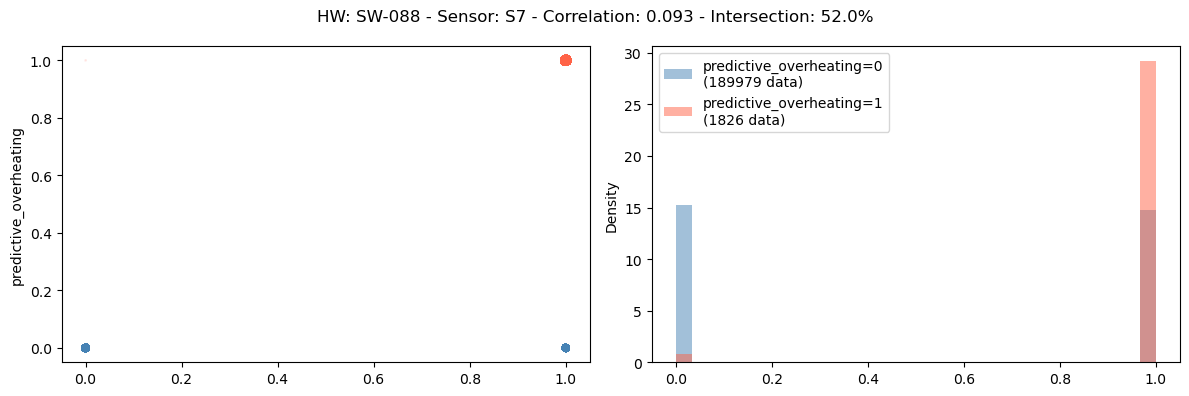

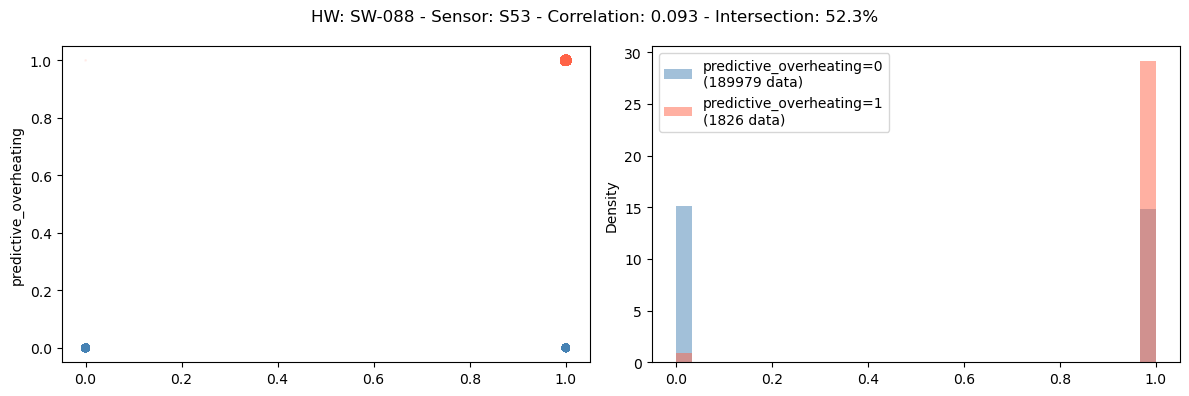

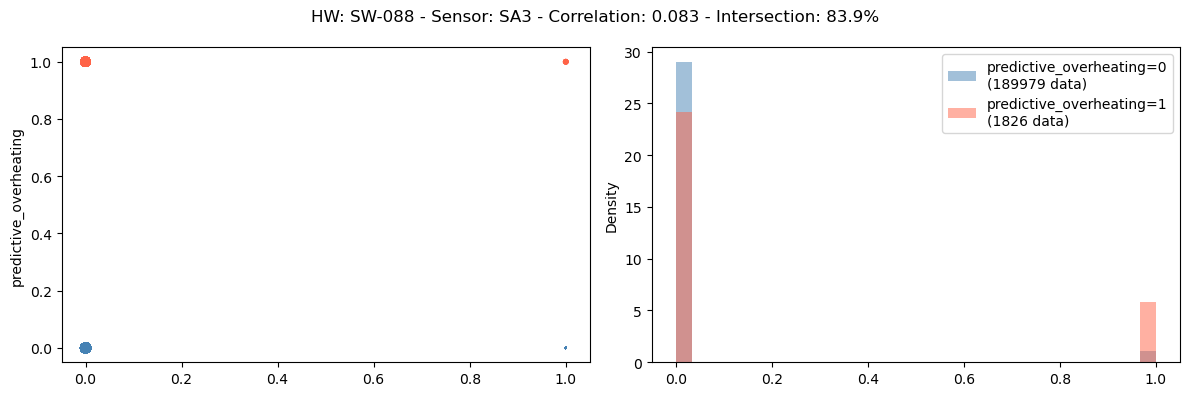

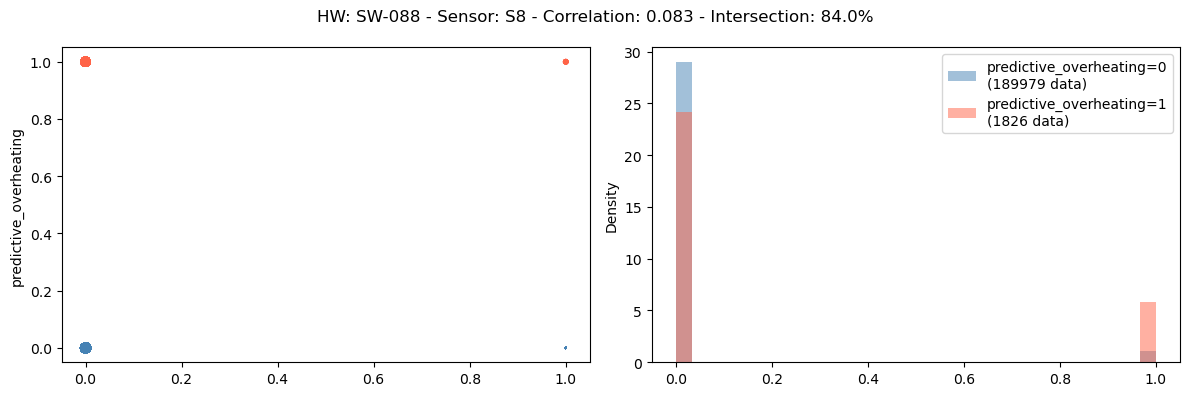

In [60]:
alarm_corr_predict = correlations(cov_matrix_pred_alarms, [*useful_sensors, 'predictive_overheating'], 'predictive_overheating')

top = 10
correl_sensors = alarm_corr_predict["Sensors"].tolist()[:top]
correl_values  = alarm_corr_predict["Correlations"].tolist()[:top]

plot_correlations(df_final_088, 'predictive_overheating', correl_sensors[:4], alarm_corr_predict.head(4), 'SW-088')

In [61]:
normal_count = df_final_088.filter( 'predictive_overheating=0' ).count()
predictive_count = df_final_088.filter( 'predictive_overheating=1' ).count()
print(
    f"Data are divided into two classes:\n"
    f" 0: normal\t\twith {normal_count} data \t({normal_count / (normal_count + predictive_count):.1%})\n"
    f" 1: before overheating\twith {predictive_count}   data \t({predictive_count / (normal_count + predictive_count):.1%})\n"
)

Data are divided into two classes:
 0: normal		with 189979 data 	(99.0%)
 1: before overheating	with 1826   data 	(1.0%)



## Blocks between fault signals

Following a conceptually similar approach to the creation of BlockID, a new grouping flag called __BlockHeat__ is introduced. <br> This flag uniquely identifies consecutive data segments that span from one alarm signal to the next (continuous '1's in the overheating signal are discarded).

In [62]:
def add_heat_blocks(df, minBlockLength=2, debug=True):

    w = Window.partitionBy( lit(0).alias("auxiliary") ).orderBy("when")

    df = df.withColumn("new_block_flag", when(lag("overheating", 1).over(w) == 1, lit(1)).otherwise(lit(0)))
    df = df.withColumn("oldBlockHeat", spark_sum("new_block_flag").over(w) + lit(1)) #old cause some blocks will be eliminated
    
    
    # delete last BlockHeat if there is no overheating in it
    last_row = df.orderBy(col("when").desc()).first()
    last_heating_value = last_row["overheating"]
    last_BlockHeat = last_row["oldBlockHeat"]
    if last_heating_value != 1:
        df = df.where(col("oldBlockHeat") < last_BlockHeat)

    block_counts = df.groupBy("oldBlockHeat").count().filter(col("count") >= minBlockLength)
    df = df.join(block_counts.select("oldBlockHeat"), on="oldBlockHeat", how="inner") # inner join to retain only block a with sufficient length

    w = Window.partitionBy("oldBlockHeat").orderBy("when")
    # rename in order the blocks after we applyed the filter
    distinct_blocks = df.select("oldBlockHeat").distinct().orderBy("oldBlockHeat") \
                        .withColumn("BlockHeat", row_number().over(Window.orderBy("oldBlockHeat")))
    df = df.join(distinct_blocks, on="oldBlockHeat", how="left")

    # create column for time relative to overheating
    w = Window.partitionBy("BlockHeat").orderBy("when")
    overheat_times = ( df.groupBy("BlockHeat").agg(spark_max("when").alias("TimeOverheating")) )
    df = df.join(overheat_times, on="BlockHeat", how="left")
    df = df.withColumn( "MinToOverheating",( col("TimeOverheating")-col("when") ) / 60 )

    if debug:
        return df.orderBy("when")
    else:
        return df.drop("new_block_flag", "oldBlockHeat", "TimeOverheating").orderBy("when")

In [63]:
# just removing double 1,1 signals
df_maintenance = add_heat_blocks( df_final_088, minBlockLength=2, debug=True )

In [64]:
# example with full debug table
df_maintenance.where( (col("when")<=1601511030) & (col("when")>=1601510490) )\
.select("when","window_start","overheating","new_block_flag","BlockHeat","TimeOverheating","MinToOverheating")\
.orderBy(col("when").asc()).show(10)

+----------+-------------------+-----------+--------------+---------+---------------+----------------+
|      when|       window_start|overheating|new_block_flag|BlockHeat|TimeOverheating|MinToOverheating|
+----------+-------------------+-----------+--------------+---------+---------------+----------------+
|1601510490|2020-10-01 00:01:00|          0|             0|        1|     1601510790|             5.0|
|1601510550|2020-10-01 00:02:00|          0|             0|        1|     1601510790|             4.0|
|1601510610|2020-10-01 00:03:00|          0|             0|        1|     1601510790|             3.0|
|1601510670|2020-10-01 00:04:00|          0|             0|        1|     1601510790|             2.0|
|1601510790|2020-10-01 00:06:00|          1|             0|        1|     1601510790|             0.0|
|1601510910|2020-10-01 00:08:00|          0|             1|        2|     1601597190|          1438.0|
|1601510970|2020-10-01 00:09:00|          0|             0|        2|    

In [65]:
grouped_blocks = df_maintenance.groupBy("BlockHeat").count().orderBy(col("count").desc())

range_blocks = grouped_blocks.withColumn(
    "Block size (rows)",
    when(col("count").between(1, 30), "1-30")
    .when(col("count").between(31, 100), "31-100")
    .when(col("count").between(101, 500), "101-500")
    .when(col("count").between(501, 1000), "501-1000")
    .when(col("count").between(1001, 1500), "1001-1500")
    .when(col("count").between(1501, 2000), "1501-2000")
    .when(col("count").between(2001, 4000), "2001-4000")
    .when(col("count") > 4000, ">4000")
    .otherwise("Other")
)

range_blocks_grouped = range_blocks.groupBy("Block size (rows)").agg(count("*").alias("How many blocks"))\
    .orderBy(
        when(col("Block size (rows)") == "1-30", 1)
        .when(col("Block size (rows)") == "31-100", 2)
        .when(col("Block size (rows)") == "101-500", 3)
        .when(col("Block size (rows)") == "501-1000", 4)
        .when(col("Block size (rows)") == "1001-1500", 5)
        .when(col("Block size (rows)") == "1501-2000", 6)
        .when(col("Block size (rows)") == "2001-4000", 7)
        .when(col("Block size (rows)") == ">4000", 8)
        .otherwise(8)
    )

range_blocks_grouped.show()

+-----------------+---------------+
|Block size (rows)|How many blocks|
+-----------------+---------------+
|             1-30|             15|
|           31-100|              5|
|          101-500|             14|
|         501-1000|             20|
|        1001-1500|             32|
|        2001-4000|              4|
|            >4000|              3|
+-----------------+---------------+



Considering the above table we have decided to recalculate __df_maintenance__ by excluding blocks with size <= 30, as they would introduce noise into the analysis. <br> These blocks correspond to cases where, following an initial overheating alert, a second one occurs shortly after. However, since both signals are likely part of the same phenomenon, for preventive purposes it is sufficient to be able to predict the first of the two.

In [66]:
df_maintenance = add_heat_blocks( df_final_088, minBlockLength=31, debug=False )

## Sensors behavior

To predict future faults, it is essential to analyze the behavior of the sensors most correlated with overheating fenomena. <br> To do this, we used the newly created block structure to aggregate sensor data based on the time at which it was acquired relative to the upcoming alarm signal. This allows us to compute, for each sensors, metrics such as count, mean, and error. <br> Most importantly, we calculate a time-based moving average,referred to as __rolling__, for each point by looking backward within the block over a defined time window (we selected 4 hours, another model hyperparameter). This helps extract a smoother trend, less affected by short-term fluctuations.

In [67]:
def info_overheating(df, duration, sensors, rolling):
    
    df = df.filter(col("MinToOverheating") <= duration)

    aggs = []
    for s in sensors:
        aggs.append(spark_avg(col(s)).alias(f"{s}_avg"))
        aggs.append(spark_stddev(col(s)).alias(f"{s}_std"))
        aggs.append(count(col(s)).alias(f"{s}_n"))
    
    df_summary = df.groupBy("MinToOverheating").agg(*aggs)
    
    w = Window.partitionBy(lit(0)).orderBy("MinToOverheating")
    
    for s in sensors:
        df_summary = df_summary.withColumn(f"{s}_rolling", spark_avg(f"{s}_avg").over(w.rangeBetween(-rolling, 0)) )
        df_summary = df_summary.withColumn(f"{s}_err", col(f"{s}_std")/spark_sqrt(col(f"{s}_n")) )

    return df_summary.orderBy("MinToOverheating")

In [68]:
df_info_overheating = info_overheating( df_maintenance, duration=24*60, sensors=correl_sensors, rolling = 4*60) #all in minutes

In [69]:
df_info_overheating.select("MinToOverheating","S53_n","S53_avg","S53_std","S53_err","S53_rolling").show(5)

+----------------+-----+------------------+-------------------+--------------------+------------------+
|MinToOverheating|S53_n|           S53_avg|            S53_std|             S53_err|       S53_rolling|
+----------------+-----+------------------+-------------------+--------------------+------------------+
|             0.0|   93| 0.967741935483871| 0.1776423436122122|  0.0184206529264568| 0.967741935483871|
|             1.0|   30|               0.9| 0.3051285766293647| 0.05570860145311556|0.9338709677419355|
|             2.0|   60|              0.95|0.21978417765108282|  0.0283740153267512|0.9392473118279568|
|             3.0|   65|0.9538461538461539| 0.2114510308831302|0.026227272494203577|0.9428970223325062|
|             4.0|   72|0.9722222222222222| 0.1654887956057706| 0.01950304159720582|0.9487620623104494|
+----------------+-----+------------------+-------------------+--------------------+------------------+



In [70]:
def plot_overheating(df, sensors, rolling_label="(4h)", show_minutes=60, step_minutes=1, color="blue", area=[]):
    df = df.filter(col("MinToOverheating") < show_minutes)
        
    pdf = df.toPandas()
    pdf = pdf.iloc[::step_minutes, :]
    print(f"Shows last {show_minutes} minutes with step={step_minutes}")
    # subplot
    fig, axes = plt.subplots(ceil(len(sensors)/2), 2, figsize=(12, 4.8*ceil(len(sensors)/2)))
    axes = axes.flatten()
    for i, s in enumerate(sensors):
       ax = axes[i]
       
       # errorbar standard
       ax.errorbar(pdf["MinToOverheating"], pdf[f"{s}_avg"], yerr=pdf[f"{s}_err"],
                   capsize=3, marker="o", linestyle="--", color=color, label="Average data")
       # moving average
       ax.plot(pdf["MinToOverheating"], pdf[f"{s}_rolling"],
               color="green",linewidth=2,linestyle="-",label=f"Moving average {rolling_label}")
       
       # last point in red: overheating
       last_idx = pdf["MinToOverheating"].idxmin()
       ax.scatter(pdf.loc[last_idx, "MinToOverheating"], pdf.loc[last_idx, f"{s}_avg"],
           color="red",s=80,zorder=5,label="Overheating"
       )
       if area: ax.axvspan(area[1], area[2], color=area[0], alpha=0.2, label="Near fault area")
       
       ax.set_title(f"Sensor {s}")
       ax.set_ylabel("Value")
       ax.grid(True, alpha=0.3)
       if step_minutes < 15:
           ax.set_xlabel("Minutes to Overheating")
           tick_step = 10
           x_ticks = np.arange(0, int(pdf["MinToOverheating"].max()) + 1, tick_step)
           ax.set_xticks(x_ticks)
           ax.set_xticklabels([f"{int(x)}" for x in x_ticks], rotation=90)
       else:
           ax.set_xlabel("Hours to Overheating")
           tick_step = 60  # one tick every hour
           x_ticks = np.arange(0, int(pdf["MinToOverheating"].max()) + 1, tick_step)
           ax.set_xticks(x_ticks)
           ax.set_xticklabels([f"{int(x/60)}" for x in x_ticks], rotation=90)
       ax.invert_xaxis()
       ax.legend(fontsize=10)
    plt.subplots_adjust(hspace=0.4, wspace=0.2)
    plt.show()

Note that for binary sensors, the plotted value represents the rate of occurrence of '1'and since the distribution is bimodal and discrete, displaying an error bar is technically inappropriate. Nonetheless, this representation provides a useful glimpse into the temporal behavior of the sensors.

Shows last 1440 minutes with step=20


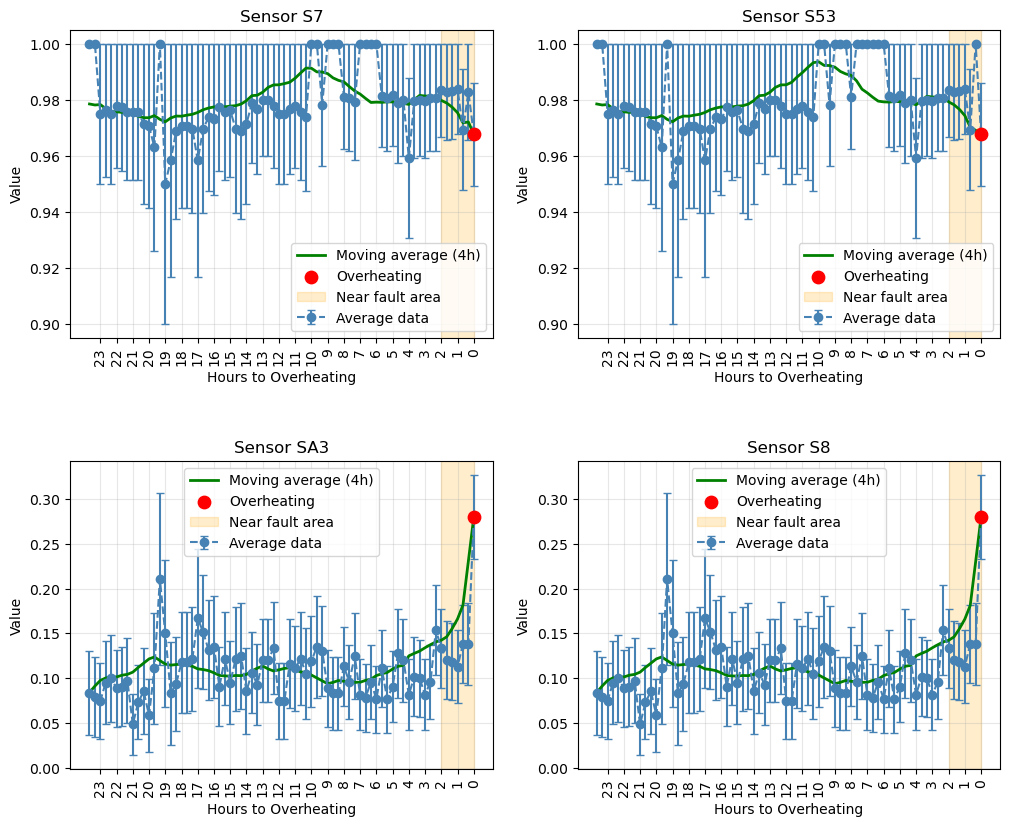

In [71]:
plot_overheating(df_info_overheating, correl_sensors[:4], rolling_label="(4h)", show_minutes=1440, step_minutes=20, color="steelblue", area=["orange",0,120])

Shows last 120 minutes with step=2


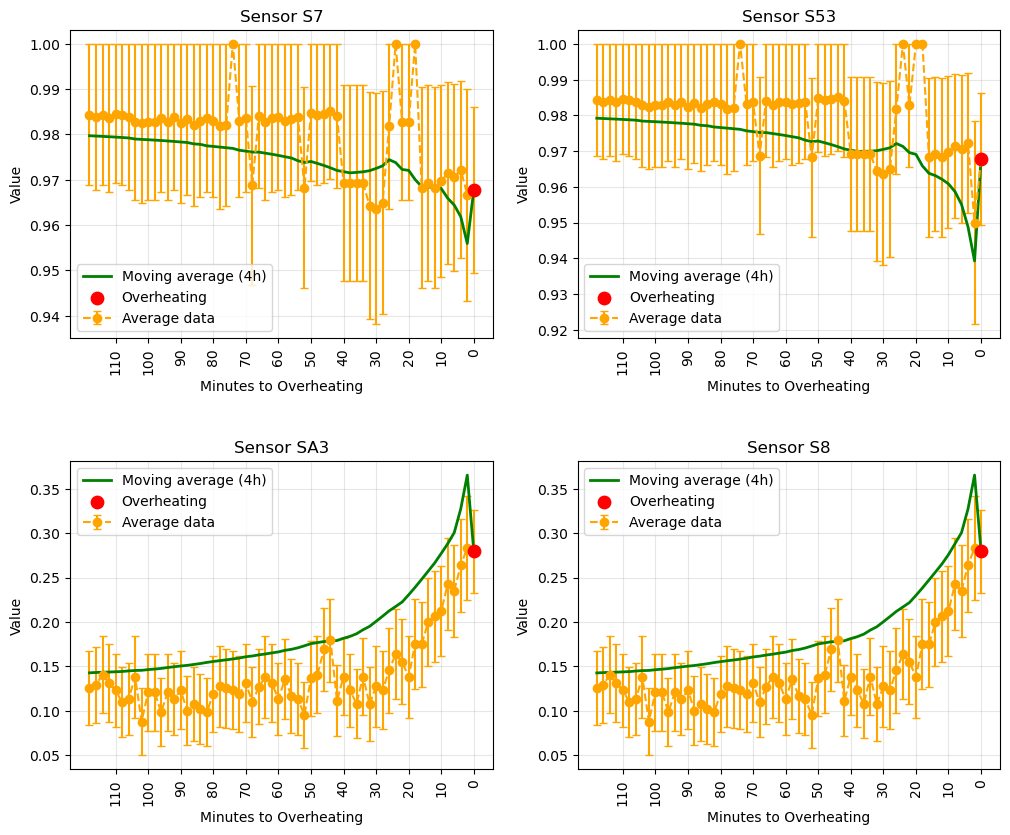

In [72]:
plot_overheating(df_info_overheating, correl_sensors[:4], rolling_label="(4h)", show_minutes=120, step_minutes=2, color="orange")

As shown in the previous plots, it may be useful to compute a moving derivative based on the __rolling__ average. <br> This allows the model to incorporate not only the absolute value of the signal but also its trend over time.

In [73]:
def add_rolling_and_derivative(df, colname, mean_minutes=4*60, debug = False): # 4*60 min = 4 h
    w = Window.partitionBy("BlockHeat").orderBy("when").rangeBetween(-mean_minutes*60, 0)
    w_all = Window.partitionBy("BlockHeat").orderBy("when")

    rolling_col = f"{colname}_rolling"
    rolling_prev = f"{colname}_rolling_prev"
    deriv_col = f"{colname}_rolling_derivative"

    df = df.withColumn(rolling_col, spark_avg(colname).over(w))
    df = df.withColumn(rolling_prev, lag(rolling_col).over(w_all))
    df = df.withColumn("when_prev", lag("when").over(w_all))
    df = df.withColumn( deriv_col, coalesce((col(rolling_col) - col(rolling_prev)) / (col("when") - col("when_prev")), lit(0)) )

    if debug:
        return df
    else:
        return df.drop(rolling_prev, "when_prev")

In [74]:
for s in correl_sensors:
    df_maintenance = add_rolling_and_derivative(df_maintenance, s, mean_minutes=4*60, debug=True)

## SVM

A first naive approach involves using a binary classifier to distinguish between the two classes defined by the __predictive_overheating__ label (Class 1: within 0 to 30 minutes before the fault; Class 0: otherwise). For this task, we employ the Support Vector Machines (SVM) algorithm, which attempts to find a separating hyperplane in the "sensor space" that best divides the two classes.
<br>
The coordinates of this hyperspace will be derived from previously computed rolling averages of the sensor, along with their rolling derivatives.
<br>
Below, we include a simple 3D plot to illustrate the concept. Note that this visualization is based on the __flag_anomaly__ label rather than __predictive_overheating__. As discussed in the correlation analysis section, the anomaly fenomena tend to separate the sensor distributions quite effectively, making it easier to visually convey the intuition behind the SVM decision boundary.

In [75]:
def plot_3d(df_data, sensors, target, view_angles=[30, 45, 0]): # angles [elevation,azimuth,roll]
    
    sensors = sensors[:3]
    pdf = df_data.select(*sensors, target).toPandas()
    
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    
    normal = pdf[pdf[target] == 0]
    anomaly = pdf[pdf[target] == 1]
    
    if len(normal) > 0:
        ax.scatter(normal[sensors[0]], normal[sensors[1]], normal[sensors[2]], 
                  c='blue', alpha=0.6, s=5, label='Normal')
    if len(anomaly) > 0:
        ax.scatter(anomaly[sensors[0]], anomaly[sensors[1]], anomaly[sensors[2]], 
                  c='red', alpha=0.8, s=5, label='Anomaly')
    
    ax.view_init(elev=view_angles[0], azim=view_angles[1], roll=view_angles[2])
    ax.set_xlabel(sensors[0])
    ax.set_ylabel(sensors[1])
    ax.set_zlabel(sensors[2])
    ax.legend()
    plt.tight_layout()
    plt.show()

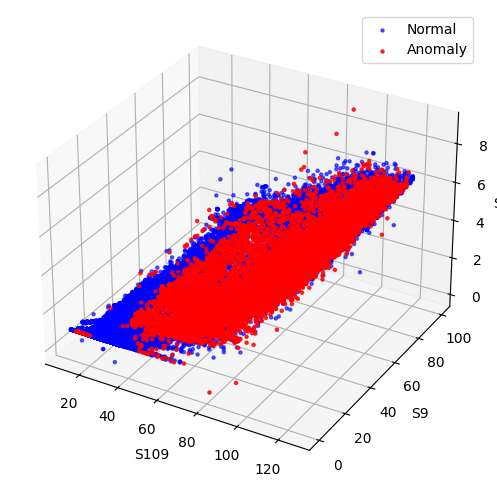

In [76]:
plot_3d(df_final_088, ["S109","S9","S126"], "flag_anomaly", [30, -60, 0] )

In [77]:
rolling_means = [ f"{s}_rolling" for s in correl_sensors ]
derivatives = [ f"{s}_rolling_derivative" for s in correl_sensors ]
selected = rolling_means + derivatives

target = "predictive_overheating"
df_data = df_maintenance.select("BlockHeat", "MinToOverheating",*selected,"overheating","predictive_overheating")

For both the SVM and the Random Forest (discussed in the next section), the following procedures are applied:

* Only 25% of the "normal data" (class 0) is randomly retained (due to imbalanced dataset condition)

* Sensor data is scaled and normalized to help ML algorithms

* Class weights are adjusted to compensate for imbalance, effectively modifying the loss function (empirically seems the most important hyperparameter)

* Predictions are performed on the entire original dataset

In [78]:
def preprocess_features(df, feature_cols, scaler=True, skim=0.25):
    
    df = df.where( (col(target) == 1) | ((col(target) == 0) & (rand(seed=123) <= skim)) )
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_feat = assembler.transform(df)\
            .select("BlockHeat","MinToOverheating",*feature_cols, *[c for c in df.columns if c not in feature_cols], "features")
    
    if not scaler:
        return df_feat, None
        
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
    scaler_model = scaler.fit(df_feat)
    df_scaled = scaler_model.transform(df_feat)
    
    return df_scaled, scaler_model

In [79]:
def svm(f_data, top_corr_alarm, target, weight_class1=1.0, seed=42):
    
    df = f_data.select("BlockHeat","MinToOverheating",*top_corr_alarm, target)
    df_prep, scaler_model = preprocess_features(df, top_corr_alarm, scaler=True)
    df_prep = df_prep.withColumn("weight", when(col(target) == 1, lit(weight_class1)).otherwise(lit(1.0)))
    assembler = VectorAssembler(inputCols=top_corr_alarm, outputCol="features_a")
    train, _ = df_prep.randomSplit([0.8, 0.2], seed=seed)
    
    svc = LinearSVC(featuresCol="features_a", labelCol=target,
                    rawPredictionCol="rawPrediction", predictionCol="prediction", weightCol="weight",
                    regParam=0.01, maxIter=1000, tol=1e-8)
    
    pipeline = Pipeline(stages=[assembler, svc]) 
    model = pipeline.fit(train)
    
    preds = model.transform(df_prep) # predict on full (original) df_data
    #preds = preds.withColumn("ProbOverheating", vector_to_array("probability")[1])
    cm = get_confusion_matrix(preds, target)
    metrics = calculate_metrics(preds, cm, target)
    
    return {"model": model, "predictions": preds, "cm": cm, "metrics": metrics, "scaler": scaler_model}

In [80]:
def get_confusion_matrix(df_predictions, target):
    
    cm_data = df_predictions.groupBy(target, "prediction").count().collect()
    cm_dict = {(row[target], row["prediction"]): row['count'] for row in cm_data}   
    tn = cm_dict.get((0, 0), 0)
    fp = cm_dict.get((0, 1), 0)  
    fn = cm_dict.get((1, 0), 0)
    tp = cm_dict.get((1, 1), 0)
    
    return pd.DataFrame([[tn, fp], [fn, tp]], index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1'])

def plot_confusion_heatmap(cm_pandas, target, algo=""):
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm_pandas.values, interpolation='nearest', cmap='Blues')
    
    # Add colorbar
    cbar = plt.colorbar(im, shrink=0.8)
    cbar.set_label('Counts', rotation=270, labelpad=15)
    
    # Add text annotations with adaptive color
    threshold = cm_pandas.values.max() / 2
    for i in range(len(cm_pandas.index)):
     for j in range(len(cm_pandas.columns)):
         color = "white" if cm_pandas.values[i, j] > threshold else "black"
         text = ax.text(j, i, cm_pandas.values[i, j], ha="center", va="center", color=color, fontsize=11)
    
    # Set labels and title
    ax.set_xticks(range(len(cm_pandas.columns)))
    ax.set_yticks(range(len(cm_pandas.index)))
    ax.set_xticklabels(cm_pandas.columns, fontsize=10)
    ax.set_yticklabels(cm_pandas.index, fontsize=10)
    ax.set_title("Confusion Matrix "+algo, fontsize=12, pad=15)
    
    plt.tight_layout()
    plt.show()

def calculate_metrics(df_predictions, cm_pandas, target):
    
    tn, fp = cm_pandas.iloc[0]
    fn, tp = cm_pandas.iloc[1]
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol=target)
    auc = evaluator.evaluate(df_predictions)
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    return {'accuracy': accuracy, 'precision': precision, 'auc': auc}

def print_metrics(metrics):
    for metric, value in metrics.items():
     print(f"{metric.capitalize()}: {value:.2f}")

In [81]:
Results_SVM = svm(df_data, selected, target, weight_class1=8)

CPU times: user 182 ms, sys: 53 ms, total: 235 ms
Wall time: 6min 7s


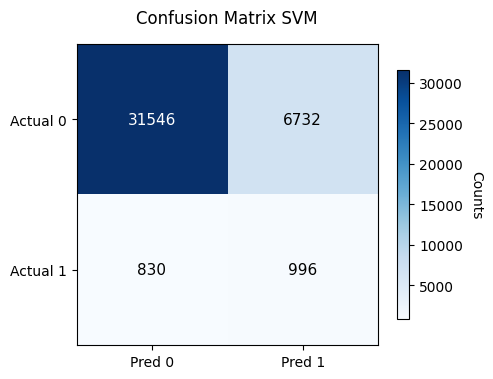

In [82]:
plot_confusion_heatmap( Results_SVM["cm"],target,algo="SVM" )

In [83]:
print( "SVM algorithm results:\n" )
print_metrics( Results_SVM["metrics"] )

SVM algorithm results:

Accuracy: 0.81
Precision: 0.13
Auc: 0.82


## Random Forest

As will be discussed in the __Maintenance in Action__ section, the key objective is to forecast the probability of an overheating event over time, therefore standard metrics shown are not particularly appropriate for evaluating the model. <br>
Nevertheless, the SVM results were not fully satisfactory, so we proceed by implementing a Random Forest model.

We begin by showing a visual representation—similar to what was done for the SVM—to illustrate how the Random Forest operates through decision trees that determine outcomes based on thresholds. These thresholds effectively define regions within the "sensors space" where data points are classified. <br> The example shown uses the __flag_anomaly__ label, as it provides a clearer visual separation, however the actual model is trained to predict __overheating__ events.

In [84]:
def plot_histograms_with_threshold(df, target, sensors, thresholds):
    
    pd_df = df.select(target, *sensors).toPandas()
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    for i, s in enumerate(sensors):
        ax = axes[i]
        
        for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
           subset = pd_df[pd_df[target] == target_val]
           ax.hist(subset[s], bins=30, alpha=0.5, color=color, 
                   label=f"{target}={target_val}", density=True)
        
        thr = thresholds.get(s, None)
        ax.axvline(x=thr, color="black", linestyle="--", linewidth=2, label="Threshold")
        
        ax.set_ylabel("Density")
        ax.set_xlabel(s)
        ax.set_title(f"{s}")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

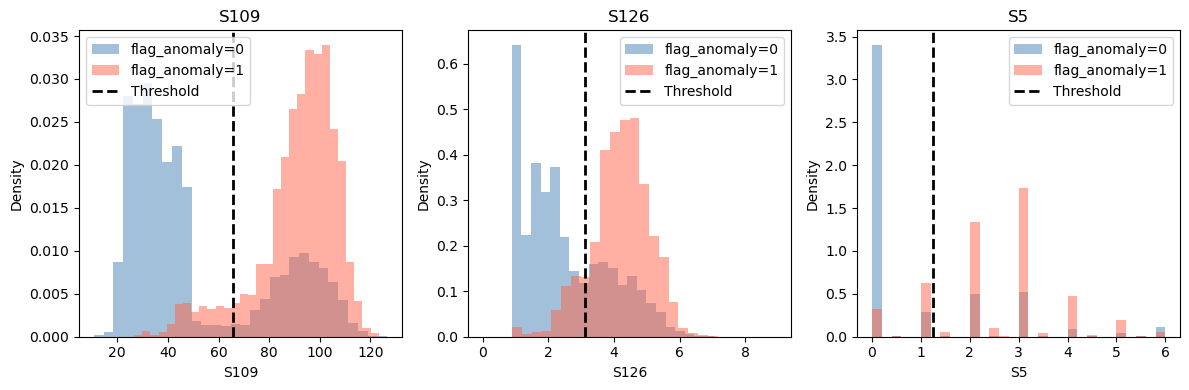

In [85]:
plot_histograms_with_threshold(df_final_088, "flag_anomaly", ["S109","S126","S5"], {"S109":65.75,"S126":3.12,"S5":1.25})

In [86]:
def random_forest(f_data, top_corr_alarm, target, weight_class1=1.0, n_trees=100, max_depth=10, seed=42):

    df = f_data.select("BlockHeat","MinToOverheating",*top_corr_alarm, target)
    df_prep, scaler_model = preprocess_features(df, top_corr_alarm, scaler=True)
    df_prep = df_prep.withColumn("weight", when(col(target) == 1, lit(weight_class1)).otherwise(lit(1.0)))
    assembler = VectorAssembler(inputCols=top_corr_alarm, outputCol="features_a")
    train, _ = df_prep.randomSplit([0.8, 0.2], seed=seed)

    rf = RandomForestClassifier(featuresCol="features_a", labelCol=target, weightCol="weight",  rawPredictionCol="rawPrediction",
        predictionCol="prediction", numTrees=n_trees, maxDepth=max_depth, seed=seed)

    pipeline = Pipeline(stages=[assembler, rf])
    model = pipeline.fit(train) 

    rf_model = model.stages[-1]
    importances = rf_model.featureImportances.toArray()
    feature_importance = sorted(zip(top_corr_alarm, importances), key=lambda x: -x[1])
    df_orig_prep, _ = preprocess_features(df, top_corr_alarm, scaler=False)
    
    preds = model.transform(df_orig_prep)
    preds = preds.withColumn("ProbOverheating", vector_to_array("probability")[1])
    cm = get_confusion_matrix(preds, target)
    metrics = calculate_metrics(preds, cm, target)

    return {"model": model, "predictions": preds, "cm": cm, "metrics": metrics, "feature_importance": feature_importance}

In [87]:
Results_RF = random_forest(df_data, selected, target, weight_class1=10 ,n_trees=500, max_depth=10)

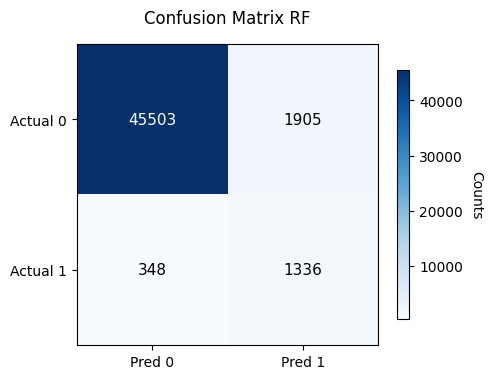

In [88]:
plot_confusion_heatmap( Results_RF["cm"],target,algo="RF" )

In [89]:
print( "Random Forest algorithm results:\n" )
print_metrics( Results_RF["metrics"] )

Random Forest algorithm results:

Accuracy: 0.95
Precision: 0.41
Auc: 0.97


Looking at the outputs, improved results can already be observed. Moreover, the Random Forest model provides a ranked list of the most relevant sensors for making predictions.

In [90]:
def print_feature_importance(feature_importance, top_n):
   print("Top sensors importance in RF:")
   print("-" * 25)
   for i, (feature, importance) in enumerate(feature_importance[:top_n]):
       clean_name = feature.split('_')[0]
       percentage = importance * 100
       print(f"{i+1}. {clean_name}:\t\t{percentage:.1f}%")

print_feature_importance(Results_RF["feature_importance"], top_n=4)

Top sensors importance in RF:
-------------------------
1. S7:		12.5%
2. S39:		12.4%
3. S40:		12.4%
4. S3:		11.1%


## Maintenance in action

Using the .transform() method from the RandomForestClassifier, we extract the probability (stored in the __ProbOverheating__ column) that the algorithm assigns to a given sensor combinations of a potential overheating event.

Traditional evaluation tools like the confusion matrix and standard metrics are not well-suited for assessing model performance in this context. Instead, we must adopt a sequential reasoning approach, as if we were monitoring the sensors value by moment in real time. <br> Below is an example where a class 1 prediction, although technically a misclassification, is in fact a valuable early signal of an impending issue. This occurs within a data sequence that notably contains a gap in the 30 minutes leading up to the overheating event. <br>
Likewise, a class 0 prediction flanked by overheating signals does not compromise the sequence’s overall predictive reliability.

In [91]:
Predictions_RF = Results_RF["predictions"]

Predictions_RF.filter("BlockHeat=3").select("BlockHeat","MinToOverheating","predictive_overheating","ProbOverheating","prediction")\
    .orderBy("MinToOverheating").show(25)

+---------+----------------+----------------------+-------------------+----------+
|BlockHeat|MinToOverheating|predictive_overheating|    ProbOverheating|prediction|
+---------+----------------+----------------------+-------------------+----------+
|        3|             1.0|                     1| 0.5153623185527165|       1.0|
|        3|            38.0|                     0|0.43655482240160354|       0.0|
|        3|            40.0|                     0|0.41624290921993595|       0.0|
|        3|            46.0|                     0|0.41624290921993595|       0.0|
|        3|            51.0|                     0|0.41624290921993595|       0.0|
|        3|            54.0|                     0|0.41624290921993595|       0.0|
|        3|            57.0|                     0|0.41624290921993595|       0.0|
|        3|            71.0|                     0|  0.482817071136887|       0.0|
|        3|            72.0|                     0|  0.482051518491047|       0.0|
|   

We now present a few predictive maintenance sequences. Since the algorithm evaluates overheating probability at individual time points, we also introduce a moving average of the last probabilities in the past, which is maybe a more worth monitoring indicator.

In [92]:
def plot_blocks(predictions_df, blocks, show=12*60, moving=1*60, colors=None):

    colors = ['steelblue', 'tomato', 'forestgreen']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, (b, color) in enumerate(zip(blocks, colors)):
        
        df_pred = predictions_df.filter(f"BlockHeat={b}").select("ProbOverheating", "MinToOverheating").orderBy("MinToOverheating")
        window_spec = Window.orderBy("MinToOverheating").rangeBetween(0,moving)
        # note: in MinToOverheating bigger positive numbers are further away in the past
        
        df_pred = df_pred.withColumn("MovingAvg", spark_avg("ProbOverheating").over(window_spec))
        df_pred_filtered = df_pred.filter(f"MinToOverheating < {show}")
        
        pd_data = df_pred_filtered.toPandas()
        
        axes[i].scatter(pd_data["MinToOverheating"], pd_data["ProbOverheating"], color=color, alpha=0.9, s=16, label="Prediction")
        axes[i].plot(pd_data["MinToOverheating"], pd_data["MovingAvg"], color=color, alpha=0.8, linewidth=2, label=f"Moving Avg {moving} min")
        
        axes[i].axhline(y=0.5, color='black', linestyle='--', linewidth=2, alpha=0.8, label="50% threshold")
        axes[i].set_xlabel("Minutes to Overheating", fontsize=16)
        axes[i].set_ylabel("Esimate fault probability", fontsize=16)
        axes[i].set_title(f"Block {b}", fontsize=18)
        axes[i].legend(fontsize=14)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim( min(pd_data["ProbOverheating"])*0.9, max(pd_data["ProbOverheating"])*1.1 )
        axes[i].tick_params(axis='both', labelsize=14)
        axes[i].invert_xaxis()

    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.tight_layout()
    plt.show()

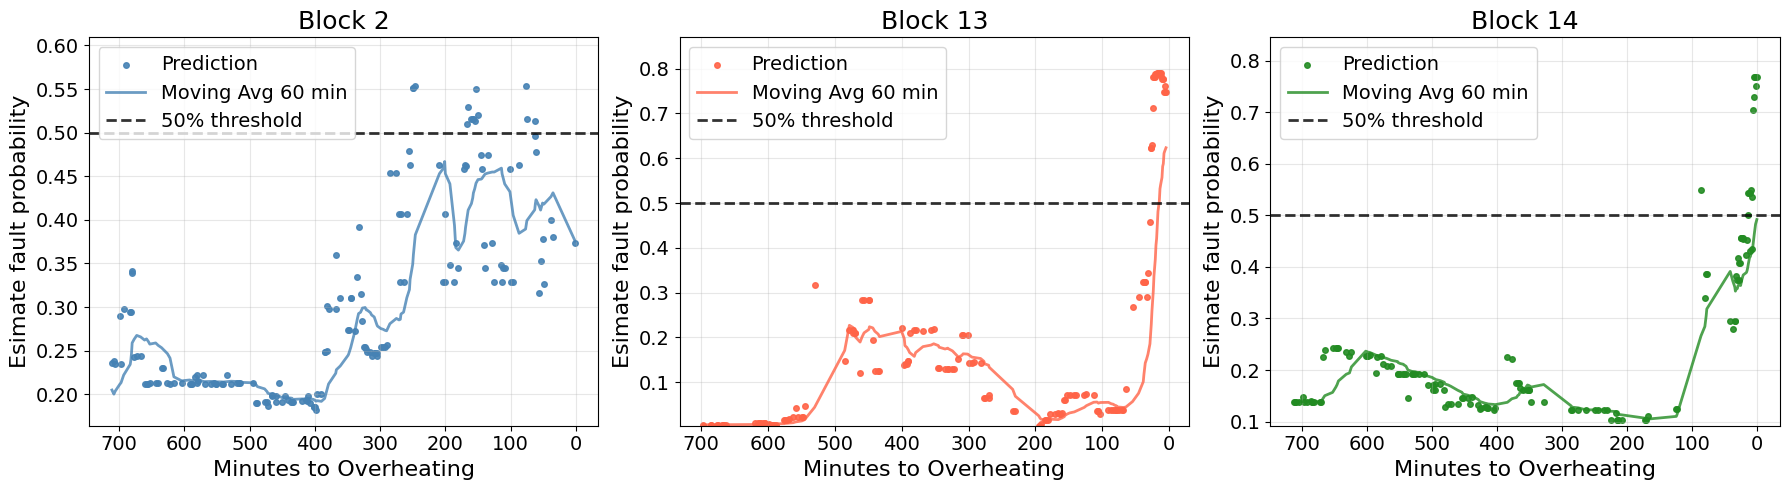

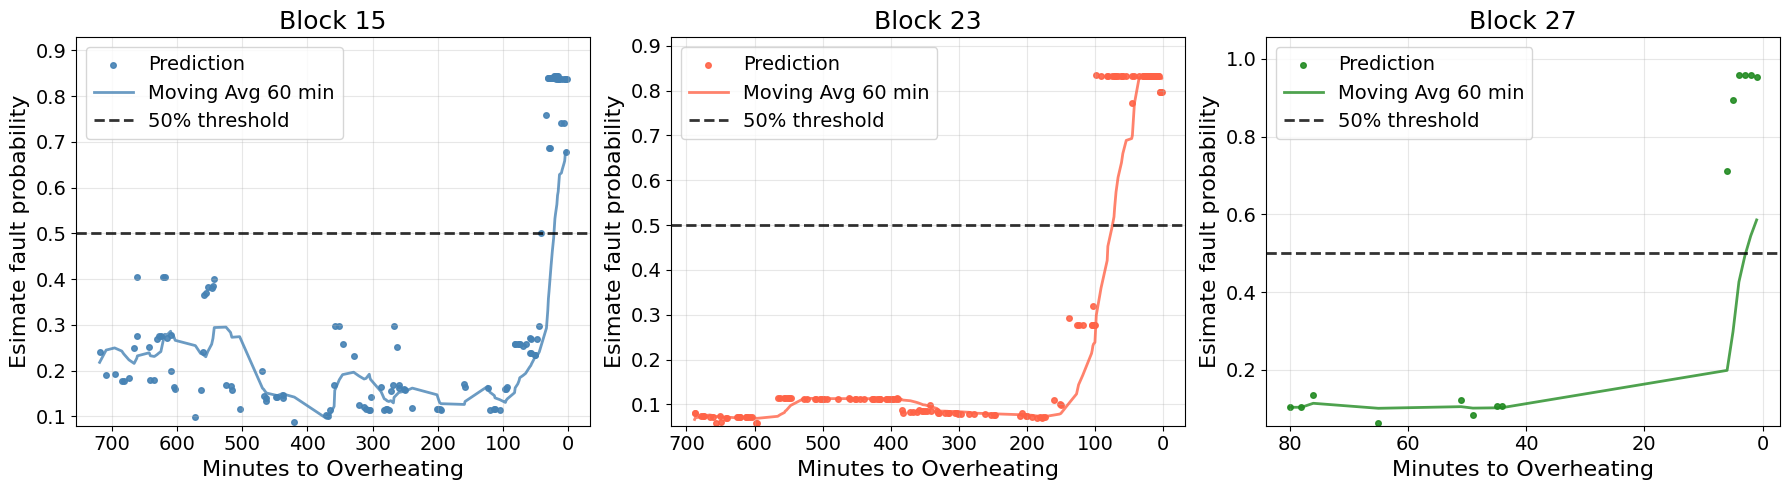

In [93]:
# Show predictive in some blocks
plot_blocks(Predictions_RF, [2,13,14])
plot_blocks(Predictions_RF, [15,23,27])

We now proceed to aggregate the insights shown in the previous plots by displaying the average trend of the estimated probability of an overheating event performs be the algorithm. The observed volatility in the estimates can be attributed to the model's limited ability to capture sequential dependencies. <br> Once again, we apply a moving average (60 minutes) to smooth the curve and color the data points based on the probability value; deeper red tones indicate a stronger warning signal for a potential overheating.

/tmp/ipykernel_24/14755945.py:37: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(x_vals, y_vals, s=40, facecolors='none', c=c_vals, edgecolors='black', linewidths=0.3, zorder=2)


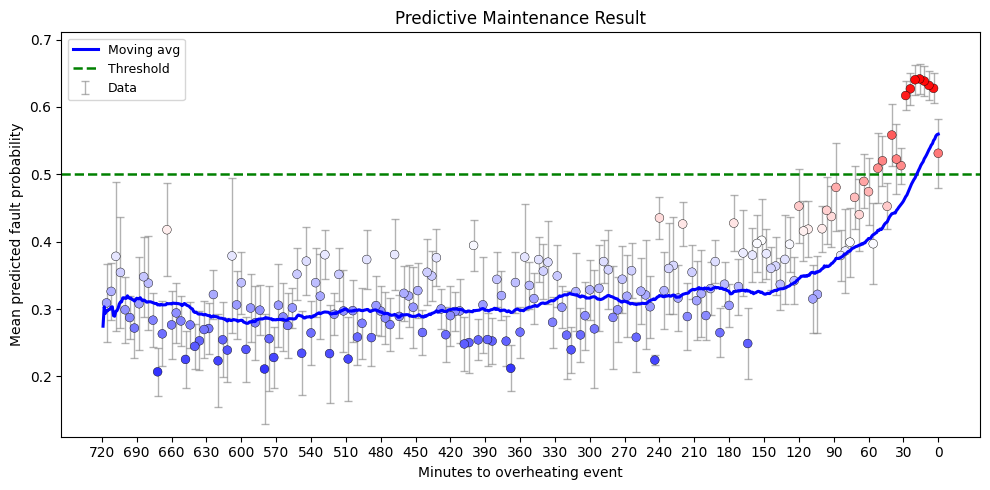

In [94]:
show   = 12*60 # minutes
moving = 1*60 # minutes
step   = 4  # minutes for plot
ticks  = 30 # minutes for axis

w = Window.orderBy("MinToOverheating").rangeBetween(0, moving)

Prob_RF = (Predictions_RF.groupBy("MinToOverheating")
    .agg(
        spark_avg(col("ProbOverheating")).alias("AvgProb"),
        spark_stddev(col("ProbOverheating")).alias("Std"),
        count(col("ProbOverheating")).alias("N"),
    )
    .withColumn("Err", col("Std") / (col("N") ** 0.5))
    .filter(col("MinToOverheating") < show)
    .orderBy("MinToOverheating")
    .withColumn("MovingAvg", spark_avg("AvgProb").over(w))
)

df_plot = Prob_RF.toPandas()

plt.figure(figsize=(10,5))

# color of points
vmin, vmax = df_plot["AvgProb"].min(), df_plot["AvgProb"].max()
norm = plt.Normalize(vmin=vmin, vmax=vmax)
colors = plt.cm.bwr(norm(df_plot["AvgProb"].values))

x_vals = df_plot["MinToOverheating"].values[::step]
y_vals = df_plot["AvgProb"].values[::step]
y_err  = df_plot["Err"].values[::step]
c_vals = colors[::step]

plt.errorbar(x_vals, y_vals, yerr=y_err, fmt='none', ecolor='gray', elinewidth=1, capsize=3, alpha=0.6, label="Data")

#plt.scatter(x_vals, y_vals, s=40, facecolors='none', c=c_vals, edgecolors=c_vals, linewidths=0.3, zorder=2)
plt.scatter(x_vals, y_vals, s=40, facecolors='none', c=c_vals, edgecolors='black', linewidths=0.3, zorder=2)

plt.plot(df_plot["MinToOverheating"], df_plot["MovingAvg"], '-', linewidth=2.2, color='blue', label="Moving avg", zorder=3)

plt.axhline(y=0.5, color='green', linestyle='--', linewidth=1.8, label="Threshold")

plt.xlabel("Minutes to overheating event")
plt.ylabel("Mean predicted fault probability")
plt.title("Predictive Maintenance Result")
plt.gca().invert_xaxis()
plt.xticks(np.arange(0, show+1, ticks))
plt.ylim(0.7*vmin, 1.1*vmax)

plt.legend(loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()

## Considerations

While sequential data analysis techniques would likely offer a more robust framework for this task, we chose to rely on the machine learning tools and domain knowledge available to us. <br> Despite this, the results are reasonably satisfactory, especially considering the simplicity and interpretability of the models implemented. <br> These models operate primarily through multi-threshold logic, classifying inputs based on whether certain sensor values fall within predefined ranges. This approach offers transparency in decision-making, unlike black-box neural networks that may yield optimal performance but lack interpretability.

A potentially more refined strategy could involve adopting a multiclass framework, enabled by an initial data analysis that segments observations into temporal phases relative to the overheating event (e.g., <1h, 1h–4h, 4h–24h, >24h). This preprocessing step would allow the model to capture more granular temporal dynamics and learn differentiated patterns across these intervals. As a result, the predictive output could take the form of probability distributions over time windows, offering a richer and more interpretable forecasting structure.

In [95]:
spark.stop()

# 6) Conclusions: Cluster parameters optimization

We wish to study the behaviour of the parallelization in our code. In order to do so we apply all the transoformation to the dataset, timing each stage of the processing to compare different configurations, mainly the number of cores and the number of partitions used in the process. Since using all the dataset was a quite heavy task we decided to restrict to one hardware analysis. SW-088 was the hardware of choice. All the functions used in the following code are found in the file **Functions.py**, while the code used to compute the heatmap is in **Optimization.ipynb**

__Spark cores/partitions trade-off__

1. **Too few partitions (under-parallelism)**  
   → Some cores idle, job slow, low resource usage.  

2. **Balanced partitions (optimal)**  
   → All cores busy, tasks balanced, good throughput.  

3. **Too many partitions (over-parallelism)**  
   → High scheduling overhead, tiny tasks, job slower.  

In [96]:
#Multicores results

nCores = [2, 4, 8, 12, 16]
nPartitions = [2, 8, 16, 32, 64, 256]


OptRes_1 = pd.read_pickle('ClusterOptimization/OptRes_4_final.pkl')
OptRes_2 = pd.read_pickle('ClusterOptimization/OptRes_5_final.pkl')

res = OptRes_1.columns.tolist()[0]
col = OptRes_1.columns.tolist()[1:]

MultiCoreAvgDF = 1/2*(OptRes_1.drop(columns = ['Resources']) + OptRes_2.drop(columns = ['Resources']))


#Single core results
SingleCore_1 = pd.read_pickle('ClusterOptimization/SingleCore_1.pkl')
SingleCore_2 = pd.read_pickle('ClusterOptimization/SingleCore_2.pkl')

SingleCoreAvgDF = 1/2*(SingleCore_1.drop(columns = ['Resources']) + SingleCore_2.drop(columns = ['Resources']))
SingleCoreAvgDF['TotalTime'] = SingleCoreAvgDF.sum(axis = 1)



MultiCoreAvgDF['TotalTime'] = MultiCoreAvgDF.sum(axis = 1)
OptRes_2

,Resources,LoadCSV,Pivot,Preprocessing,AnomalyDetection,Correlations,Predictive Maintenance
0,"(2, 2)",89.605420,214.770966,44.949996,38.439951,28.124253,13.045362
1,"(2, 8)",85.403807,194.685371,47.821326,39.765970,33.266113,17.770358
2,"(2, 16)",82.983949,202.149799,53.800481,41.618028,33.492082,21.790978
3,"(2, 32)",84.309066,195.105836,60.622357,43.216220,46.150017,29.221181
4,"(2, 64)",83.327014,198.937115,76.375747,47.644318,54.335050,40.991426
5,"(2, 256)",87.678975,209.657818,171.793122,66.407750,123.144957,112.488606
6,"(4, 2)",46.307181,155.712613,47.811603,38.021501,27.009401,12.153467
7,"(4, 8)",44.709185,105.160113,44.868077,38.675237,24.872793,13.663587
8,"(4, 16)",46.784425,106.704377,49.576346,40.437568,31.199028,19.588747
9,"(4, 32)",45.504888,108.143435,54.498218,42.062714,36.850928,24.301648


In the next plot is shown the heatmap of the total time of processing for different configurations: cores and partitions. As we can see the difference is noticible: more cores always correspond to a lower processing time. On the other hand, as expected, more partition is not always related to better performance, mainly on the case in which we have very few cores. 
The right plot also shown the projection of the heatmap along the cores, for some of the partitions. It is also incorporated the total time taken by the cluster when using only 1 core and 1 partition (no parallelization).

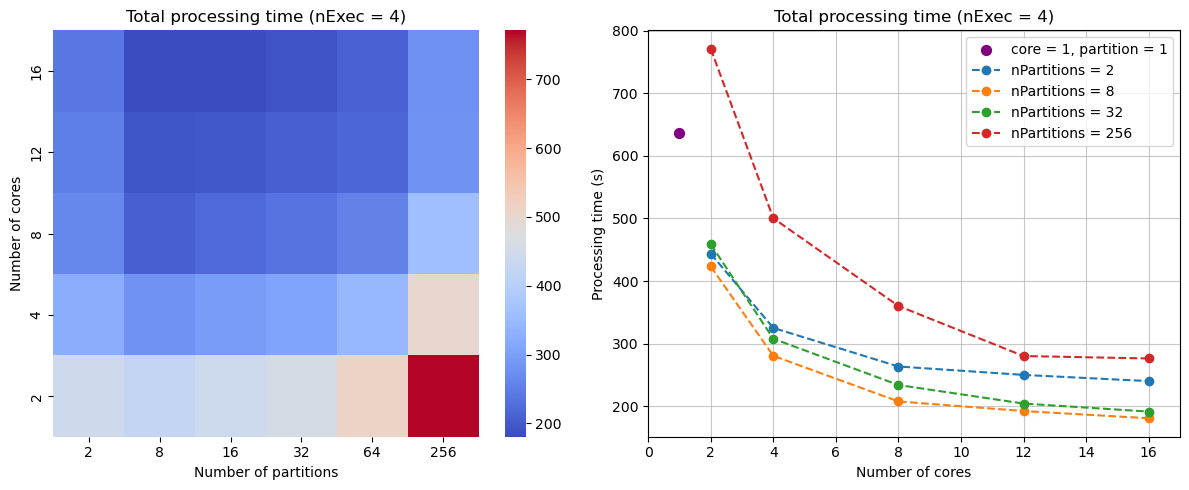

In [97]:
import seaborn as sns


TotalTime = np.reshape(MultiCoreAvgDF['TotalTime'], (5, 6))


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap on the first subplot
sns.heatmap(TotalTime, cmap="coolwarm", ax=ax[0])
ax[0].set_xticklabels(nPartitions)
ax[0].set_yticklabels(nCores)
ax[0].invert_yaxis()
ax[0].set_xlabel('Number of partitions')
ax[0].set_ylabel('Number of cores')
ax[0].set_title("Total processing time (nExec = 4)")

# Line plot on the second subplot

ax[1].scatter(1, SingleCoreAvgDF['TotalTime'], label='core = 1, partition = 1', c = 'purple', s = 50)
for i in [0, 1, 3, 5]:
    ax[1].plot(nCores, TotalTime[:, i], label=f'nPartitions = {nPartitions[i]}', linestyle='--', marker='o')


ax[1].set_xlim(0, 17)
ax[1].grid(True, alpha=0.7)
ax[1].set_xlabel('Number of cores')
ax[1].set_ylabel('Processing time (s)')
ax[1].set_title("Total processing time (nExec = 4)")
ax[1].legend()

plt.tight_layout()
plt.show()

Changing the number of executors:

In [98]:
nCores = [4, 8, 12, 16]
nExecutors = [2, 4, 6, 8]


ExecutorsAvgDF = pd.read_pickle('ClusterOptimization/CoresExecutors_1.pkl')

res = ExecutorsAvgDF.columns.tolist()[0]
col = ExecutorsAvgDF.columns.tolist()[1:]

ExecutorsAvgDF['TotalTime'] = ExecutorsAvgDF.drop(columns = ['Resources']).sum(axis = 1)


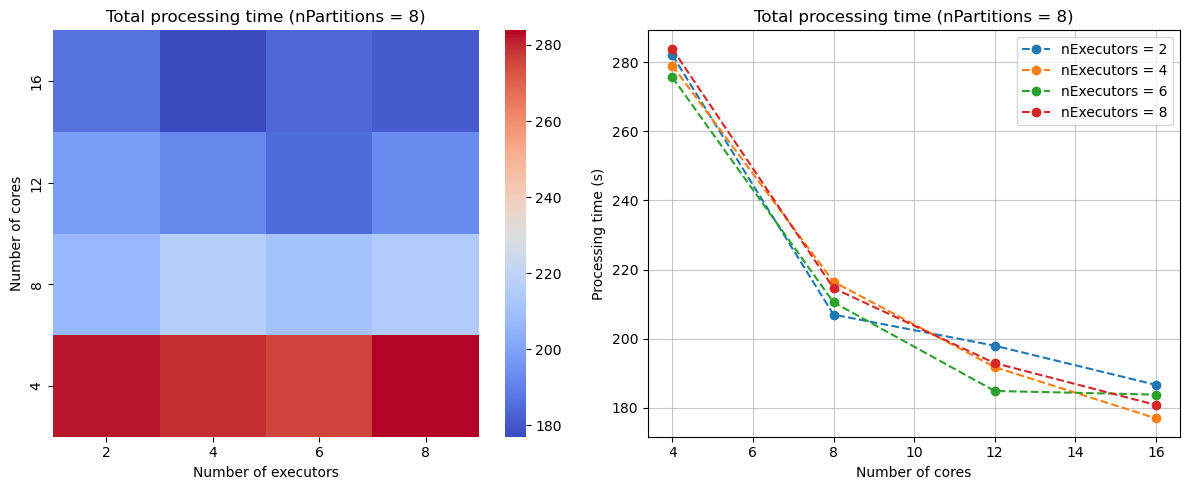

In [99]:
TotalTime = np.reshape(ExecutorsAvgDF['TotalTime'], (4, 4))


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap on the first subplot
sns.heatmap(TotalTime, cmap="coolwarm", ax=ax[0])
ax[0].set_xticklabels(nExecutors)
ax[0].set_yticklabels(nCores)
ax[0].invert_yaxis()
ax[0].set_xlabel('Number of executors')
ax[0].set_ylabel('Number of cores')
ax[0].set_title("Total processing time (nPartitions = 8)")

# Line plot on the second subplot

for i in [0, 1, 2, 3]:
    ax[1].plot(nCores, TotalTime[:, i], label=f'nExecutors = {nExecutors[i]}', linestyle='--', marker='o')


ax[1].grid(True, alpha=0.7)
ax[1].set_xlabel('Number of cores')
ax[1].set_ylabel('Processing time (s)')
ax[1].set_title("Total processing time (nPartitions = 8)")
ax[1].legend()

plt.tight_layout()
plt.show()